In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [7]:
df = pd.read_csv("../data/US_Accidents_March23_sampled_500k.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

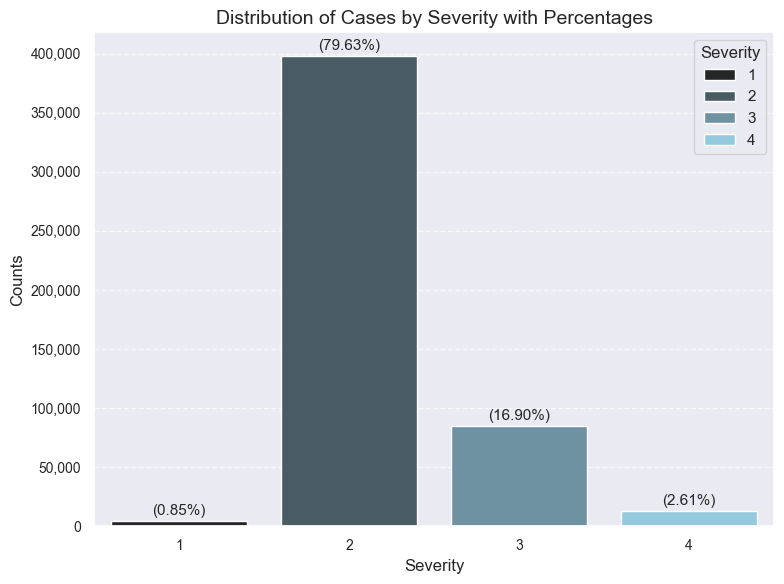

In [8]:
severity_counts = df['Severity'].value_counts().sort_index()
total_cases = df.shape[0]
severity_percentages = (severity_counts / total_cases) * 100

severity_df = pd.DataFrame({
    'Severity': severity_counts.index,
    'Counts': severity_counts.values,
    'Percentage': severity_percentages.values
})

plt.figure(figsize=(8, 6))
sns.barplot(data=severity_df, x = "Severity", y="Counts", palette='dark:skyblue', hue=severity_counts.index)
for i, row in severity_df.iterrows():
    plt.text(i, row['Counts'] + total_cases * 0.01,
             f"({row['Percentage']:.2f}%)", 
             ha='center', fontsize=11) 
    
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.title('Distribution of Cases by Severity with Percentages', fontsize=14)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
grouped_data = df.groupby(["City", 'Severity']).size().reset_index(name='Counts')
grouped_data.groupby("City")['Counts'].transform("sum")
grouped_data.pivot(index="City", columns='Severity', values='Counts').fillna(0)
def plot_severity_distribution(data, group_by_column, figsize=(12, 8), top_n=None):
    
    # grouping the data by column
    grouped_data = data.groupby([group_by_column, 'Severity']).size().reset_index(name='Counts')
    
    # total number of cases for each group_by_column
    total_counts_per_group = grouped_data.groupby(group_by_column)['Counts'].transform('sum')
    
    # calculate percentage for each severity level
    grouped_data['Percentage'] = (grouped_data['Counts'] / total_counts_per_group) * 100
    
    # include only the top N groups based on total counts 
    if top_n:
        top_groups = grouped_data.groupby(group_by_column)['Counts'].sum().nlargest(top_n).index
        grouped_data = grouped_data[grouped_data[group_by_column].isin(top_groups)]

    # pivoting the data for plotting
    pivot_counts = grouped_data.pivot(index=group_by_column, columns='Severity', values='Counts').fillna(0)
    pivot_percentages = grouped_data.pivot(index=group_by_column, columns='Severity', values='Percentage').fillna(0)

    # sorting rows in descending order by the total number of cases
    pivot_counts['Total'] = pivot_counts.sum(axis=1)
    pivot_counts = pivot_counts.sort_values(by='Total', ascending=False).drop(columns='Total')
    colors = sns.color_palette("Blues", n_colors=len(pivot_counts.columns))


    # plotting 
    ax = pivot_counts.plot(
        kind='bar', 
        stacked=True, 
        color=colors,
        figsize=figsize, 
        width=0.8
    )
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
    plt.title(f'Number of Cases by Severity and {group_by_column}', fontsize=16)
    plt.xlabel(group_by_column, fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.legend(title='Severity Level', fontsize=10)
    plt.tight_layout()
    plt.show() 

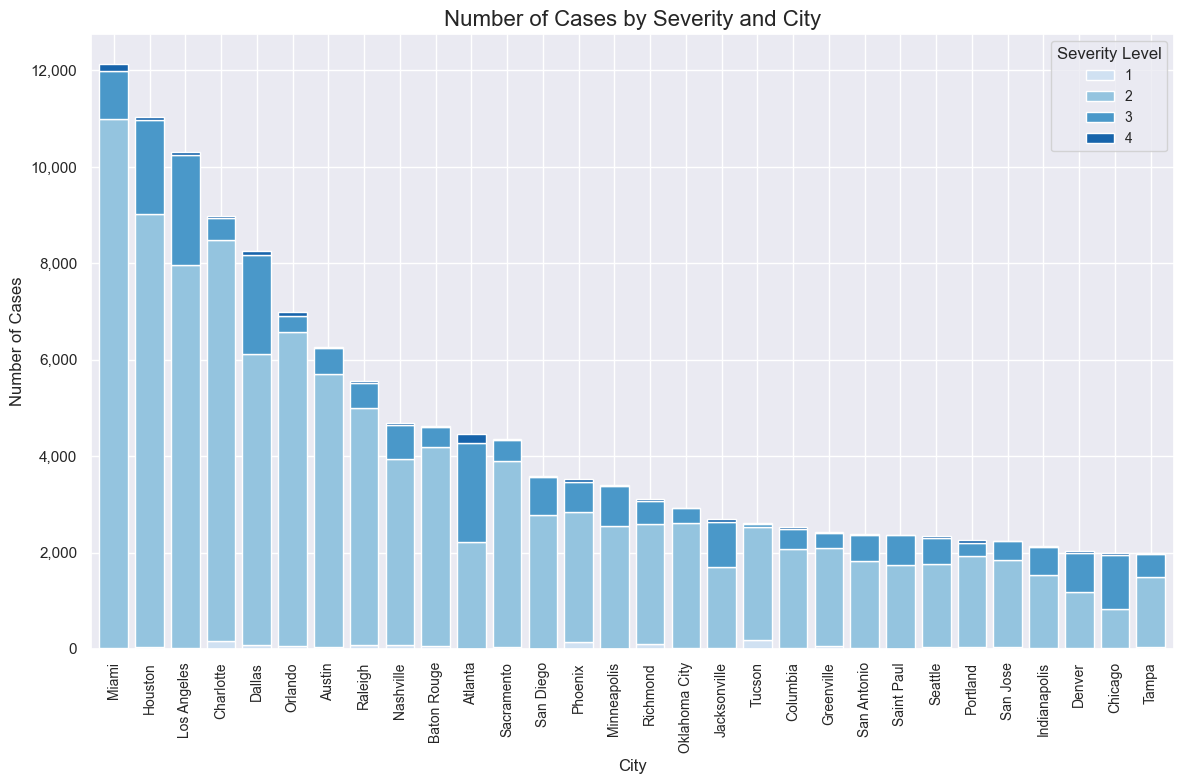

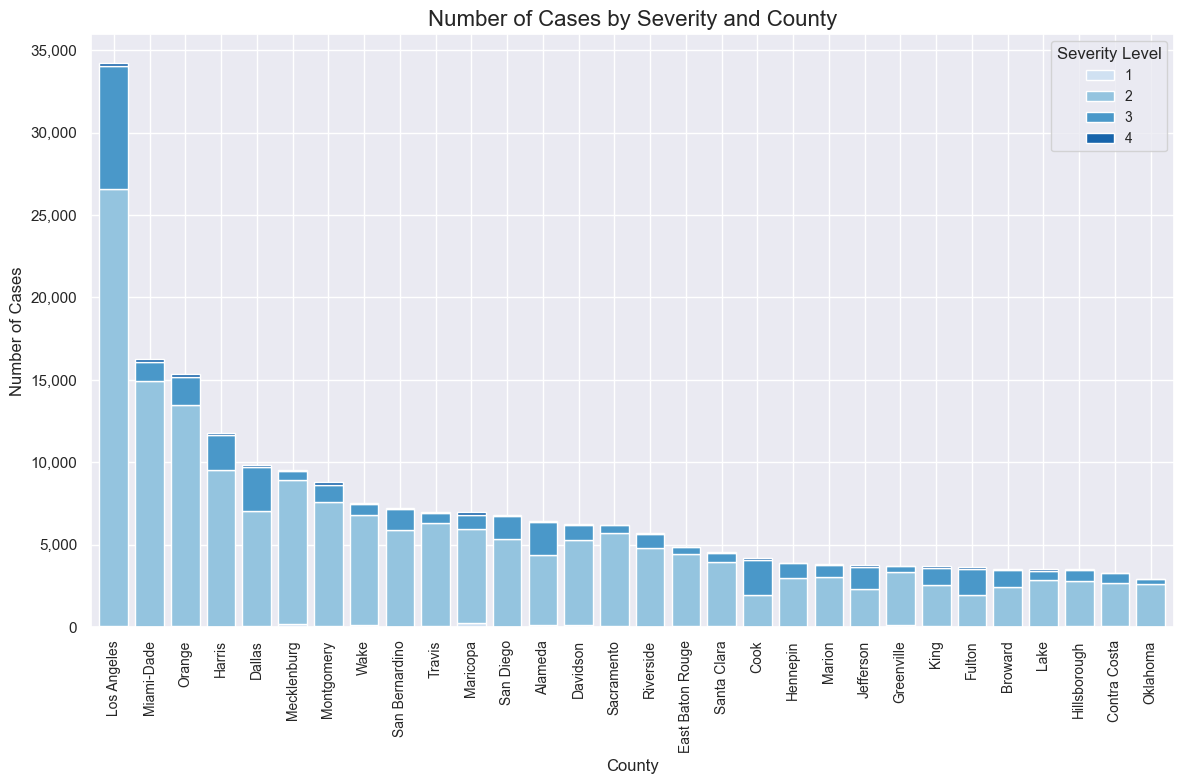

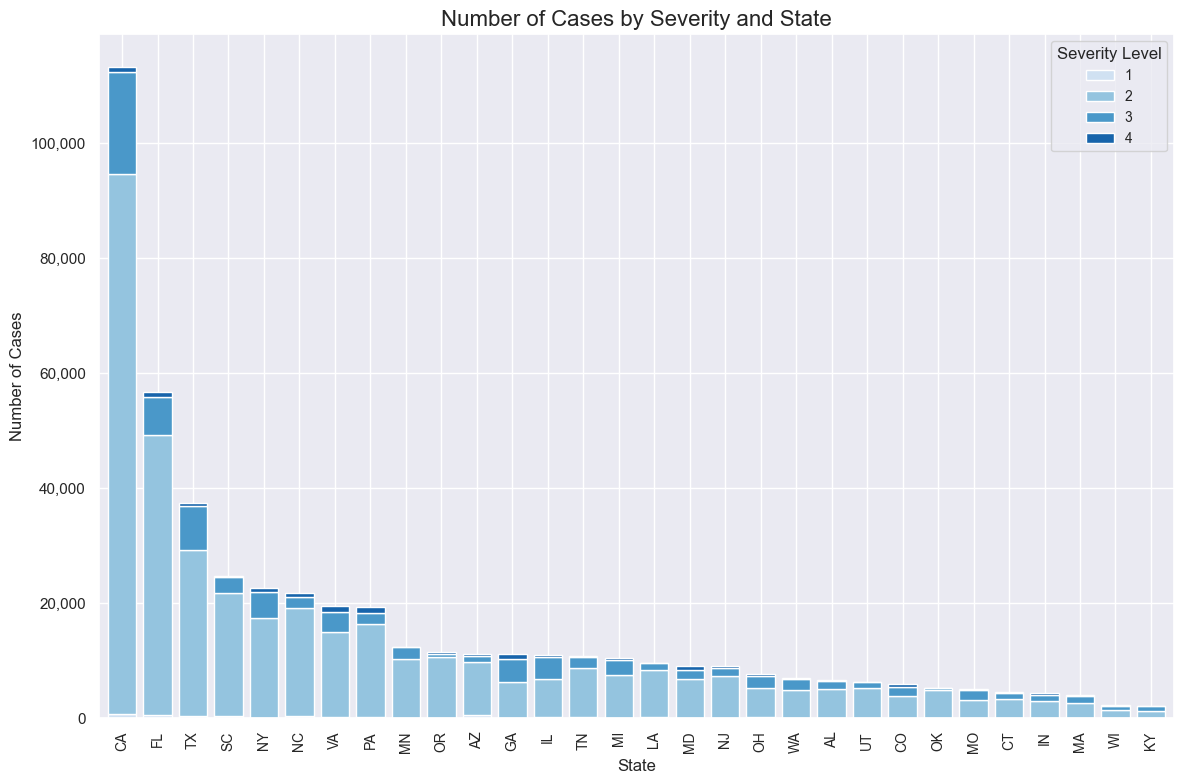

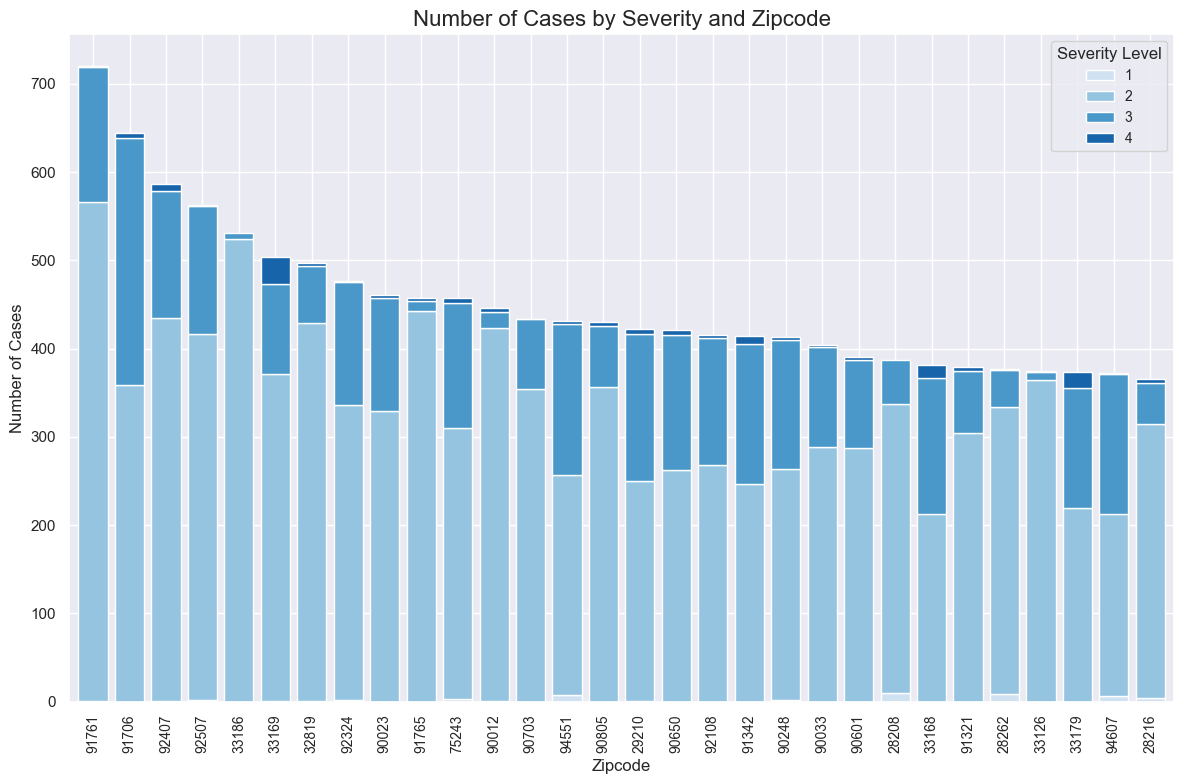

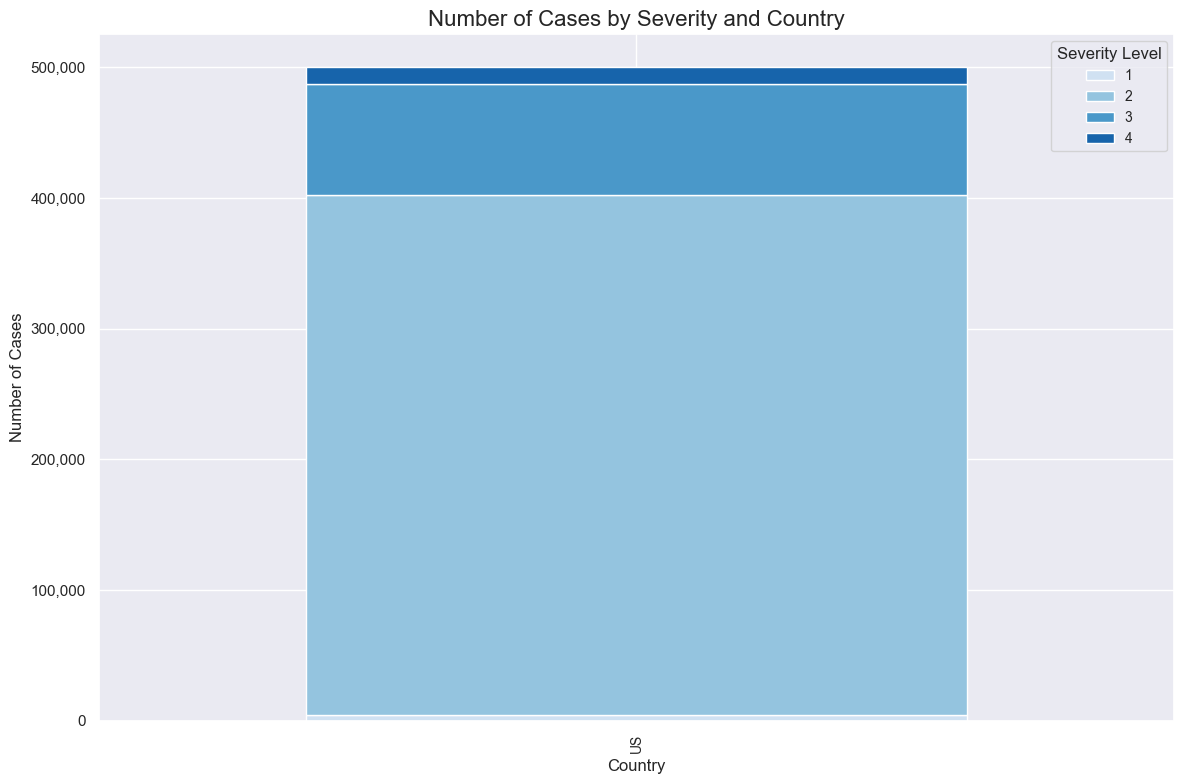

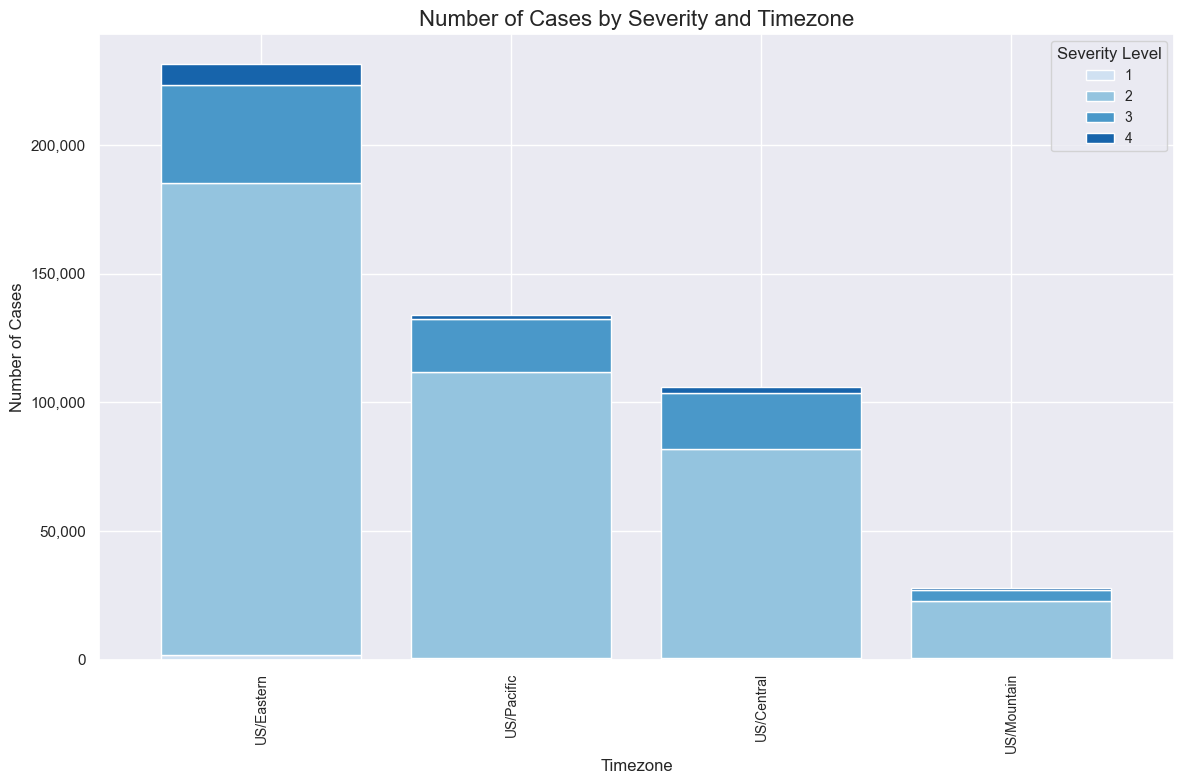

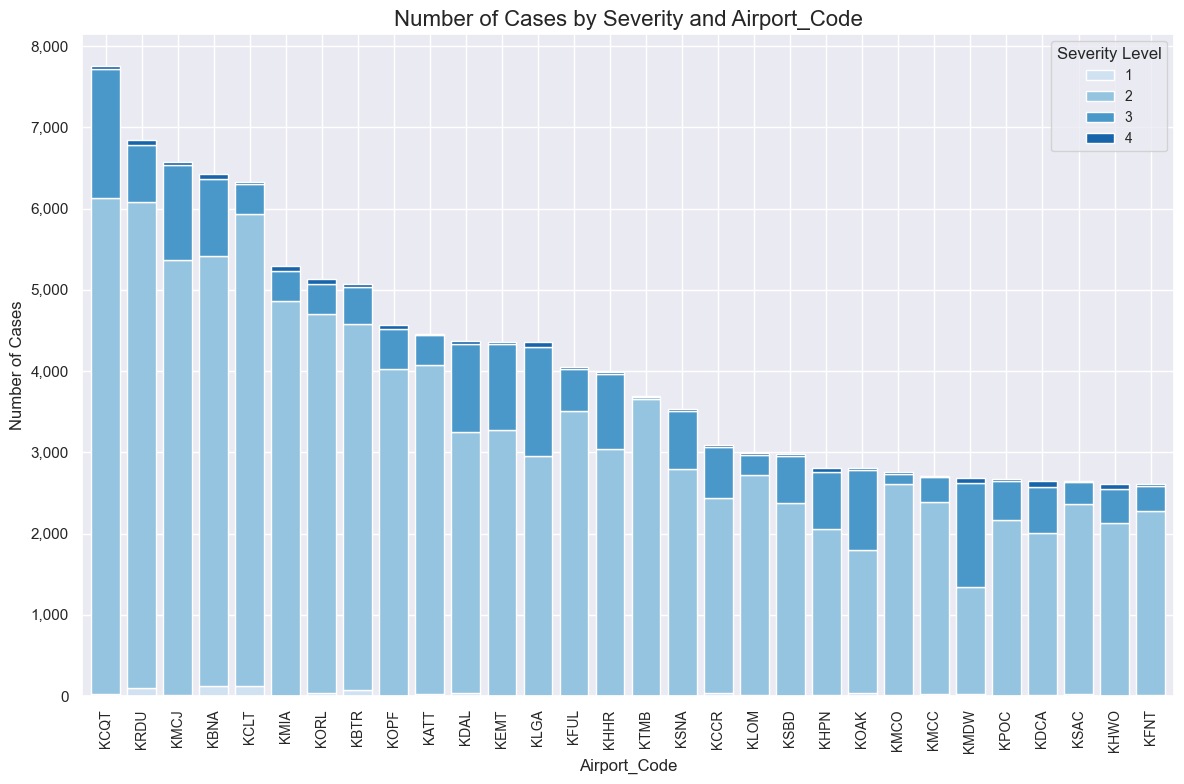

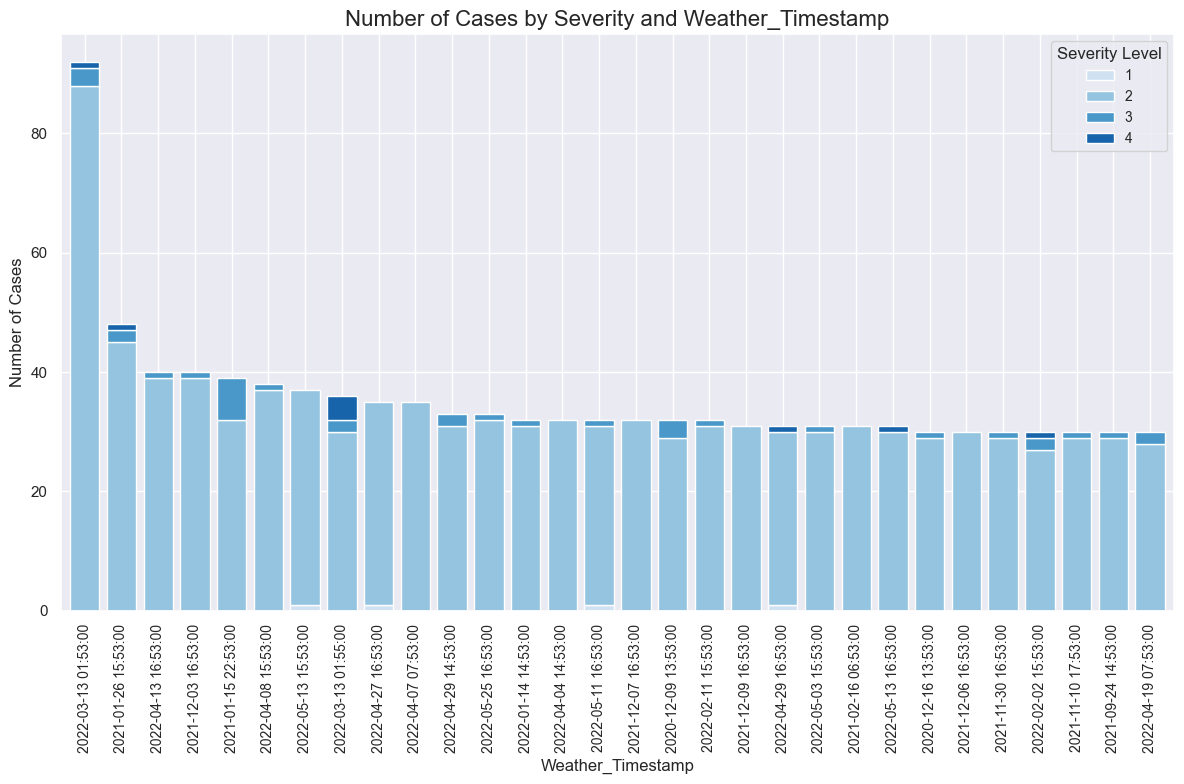

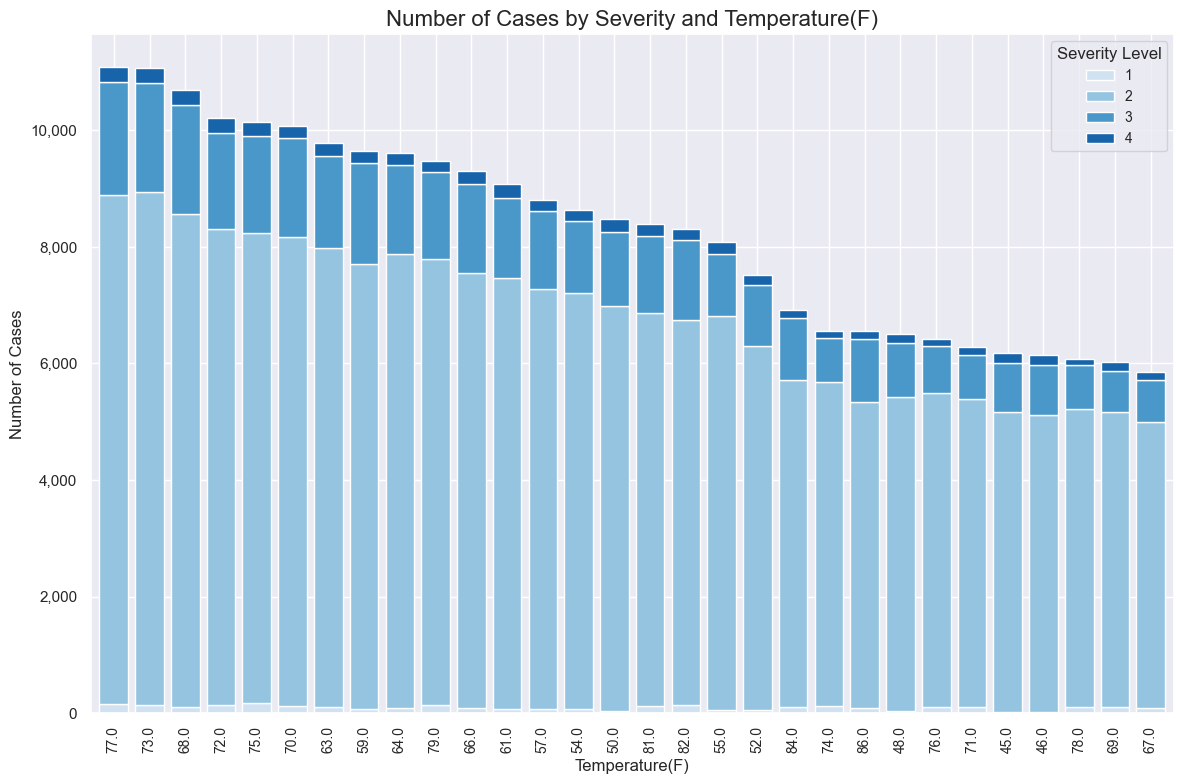

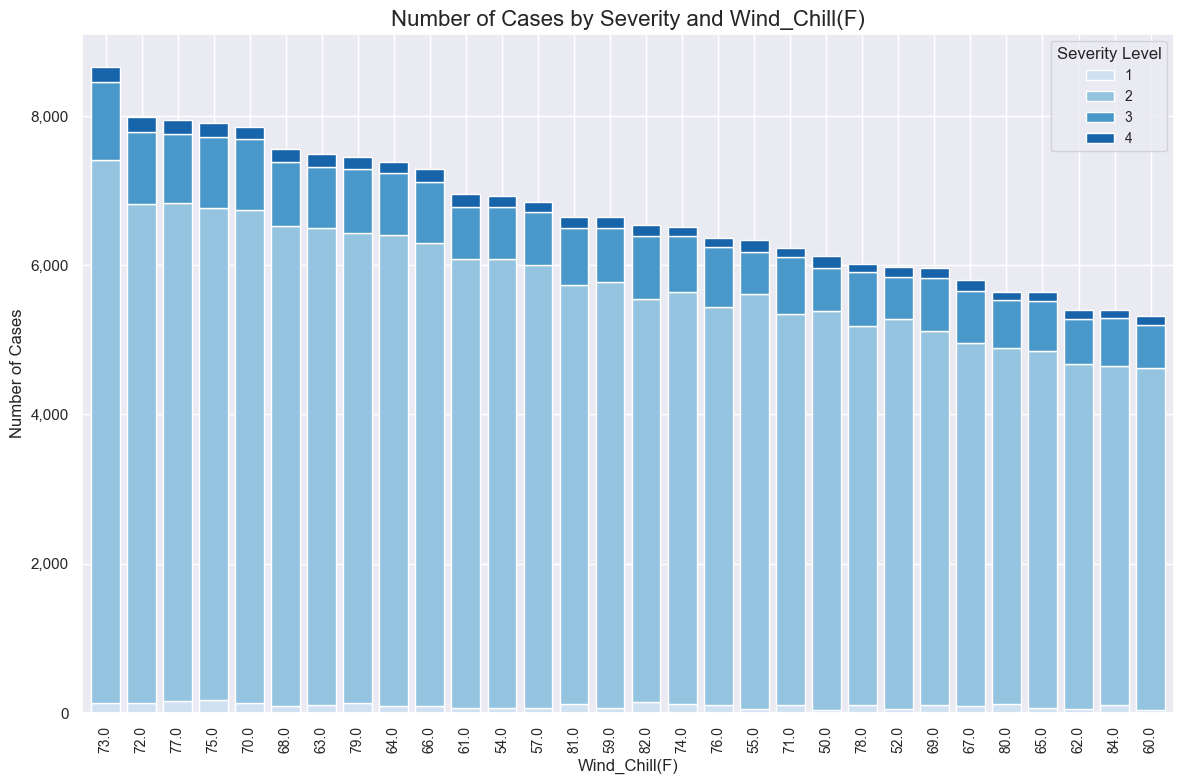

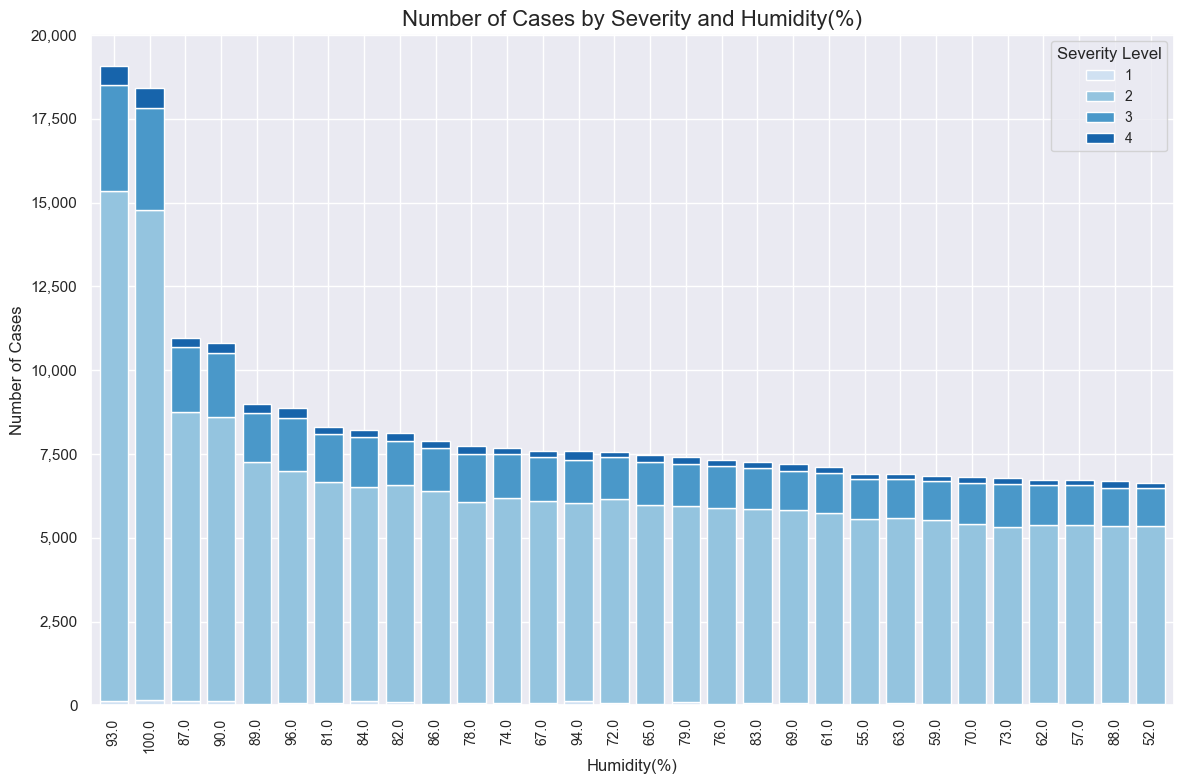

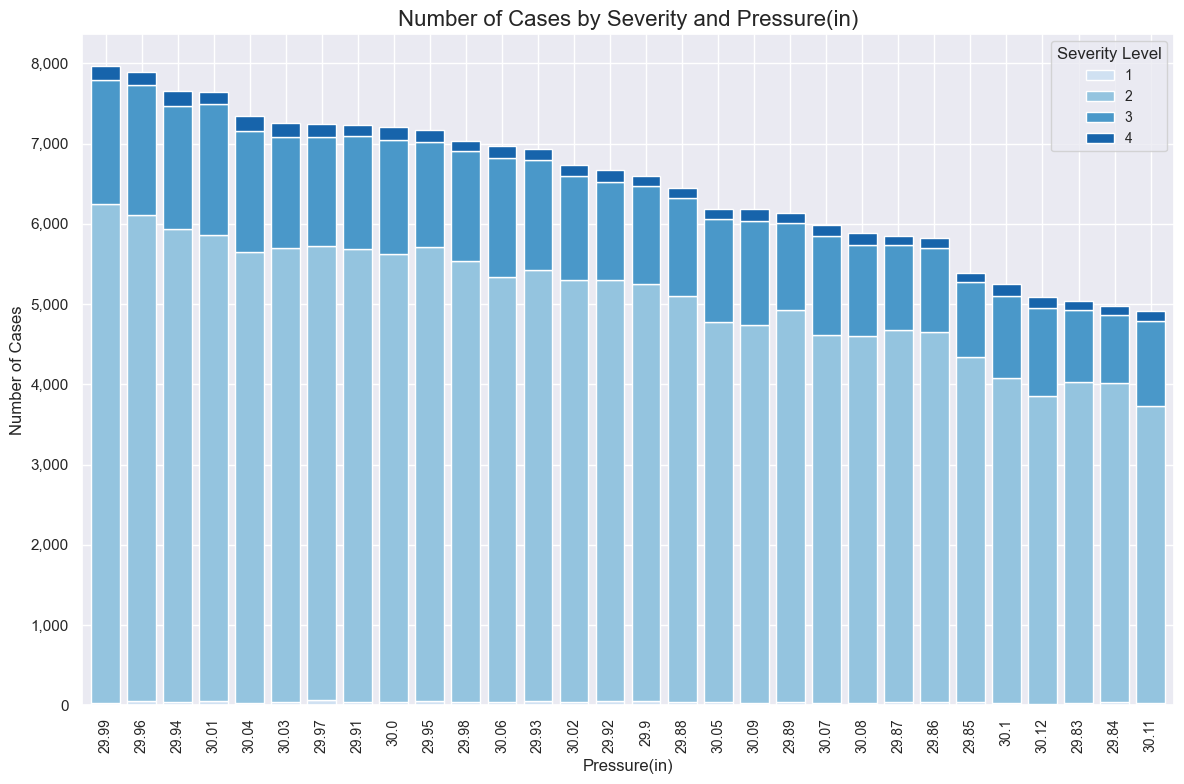

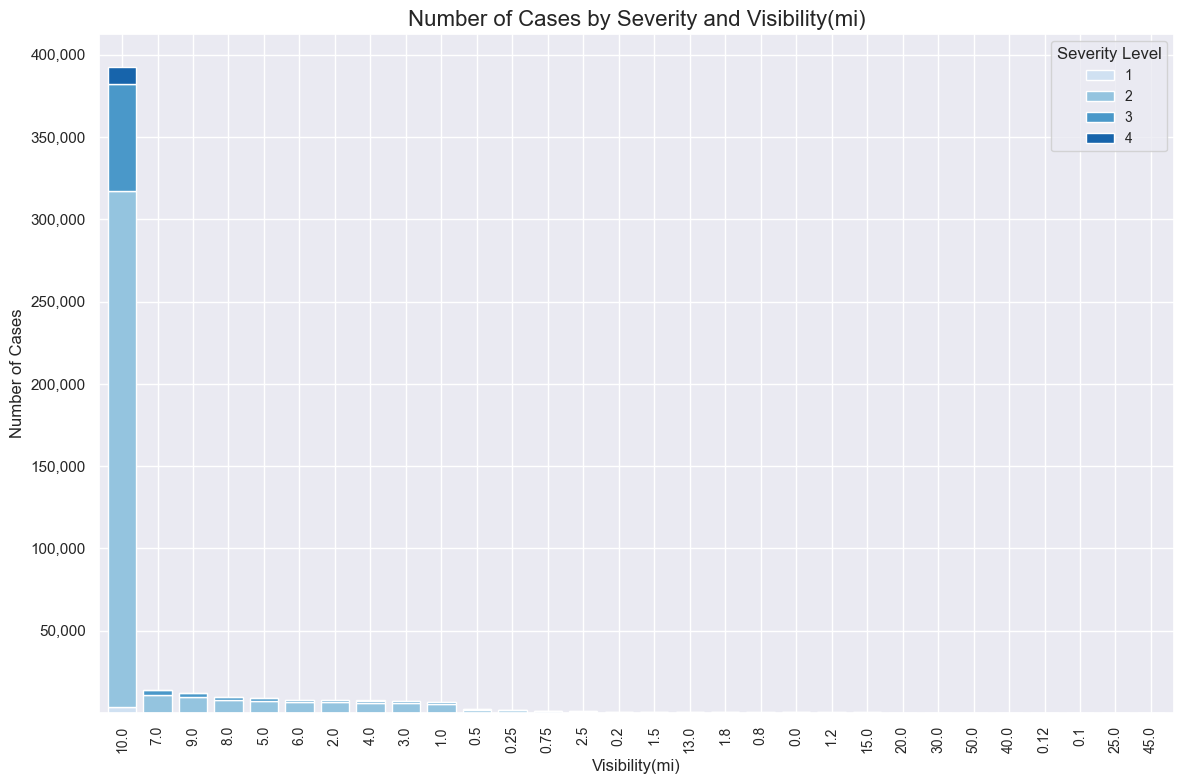

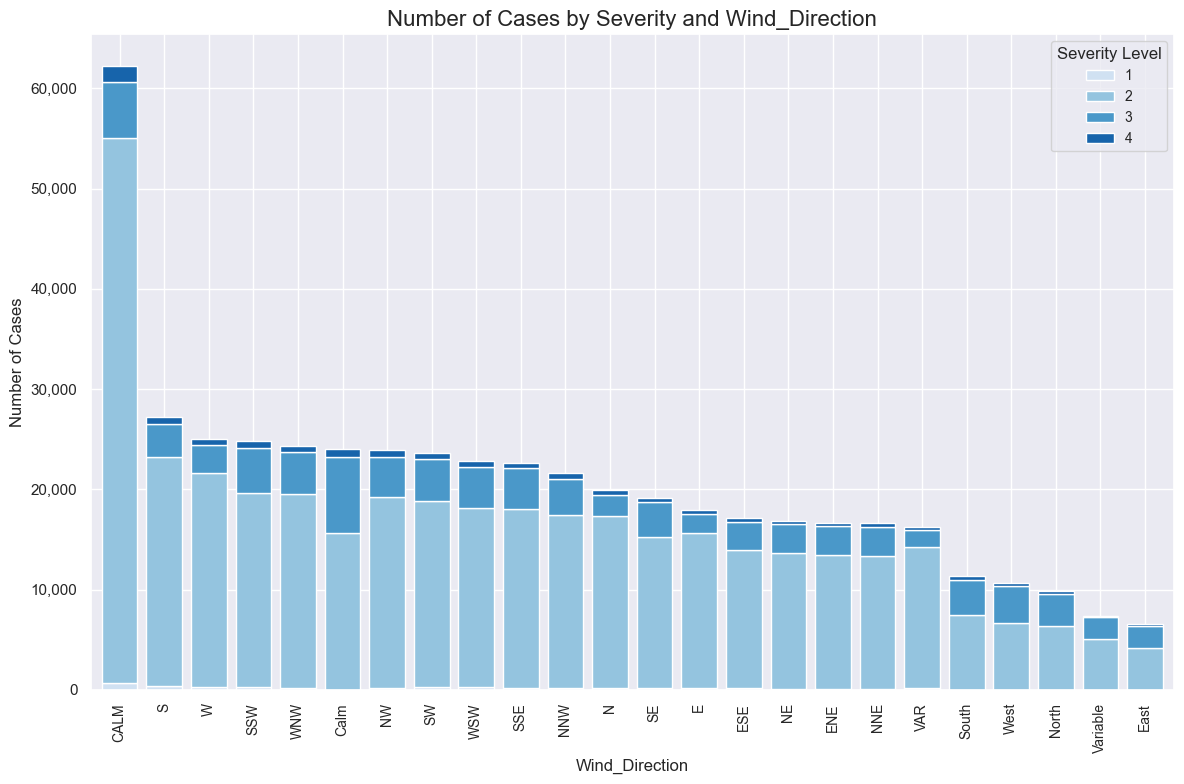

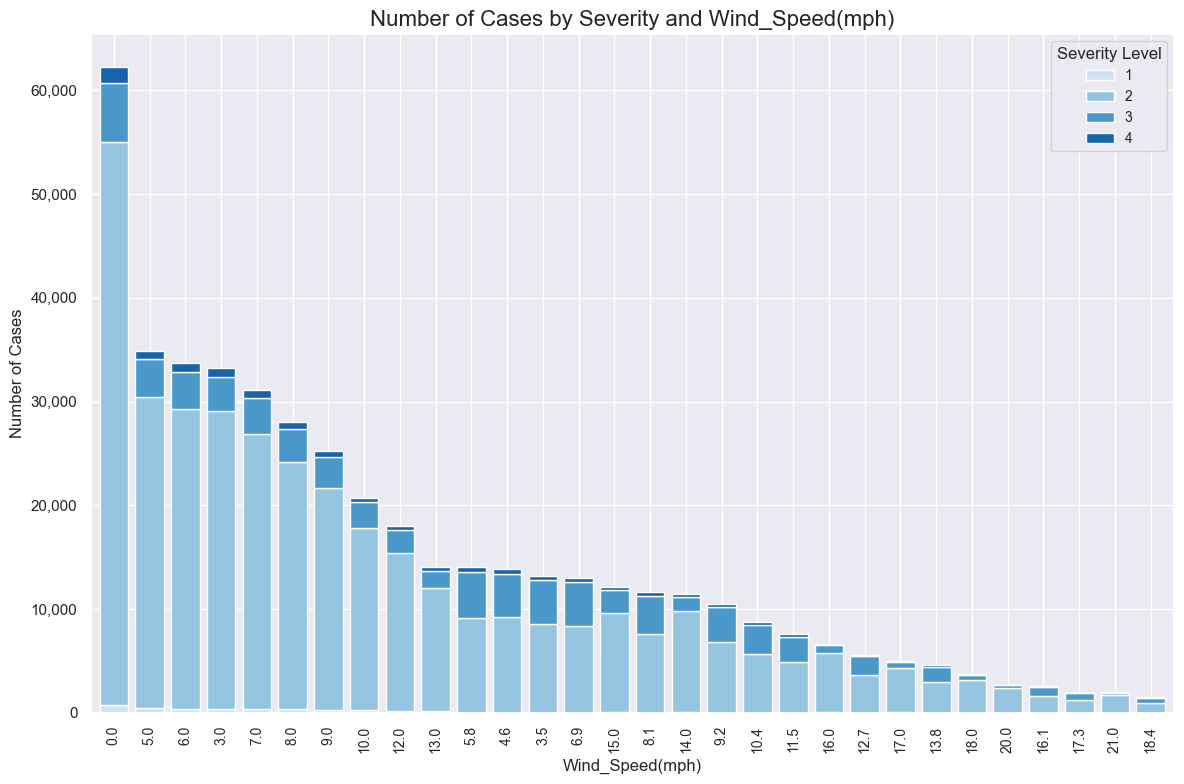

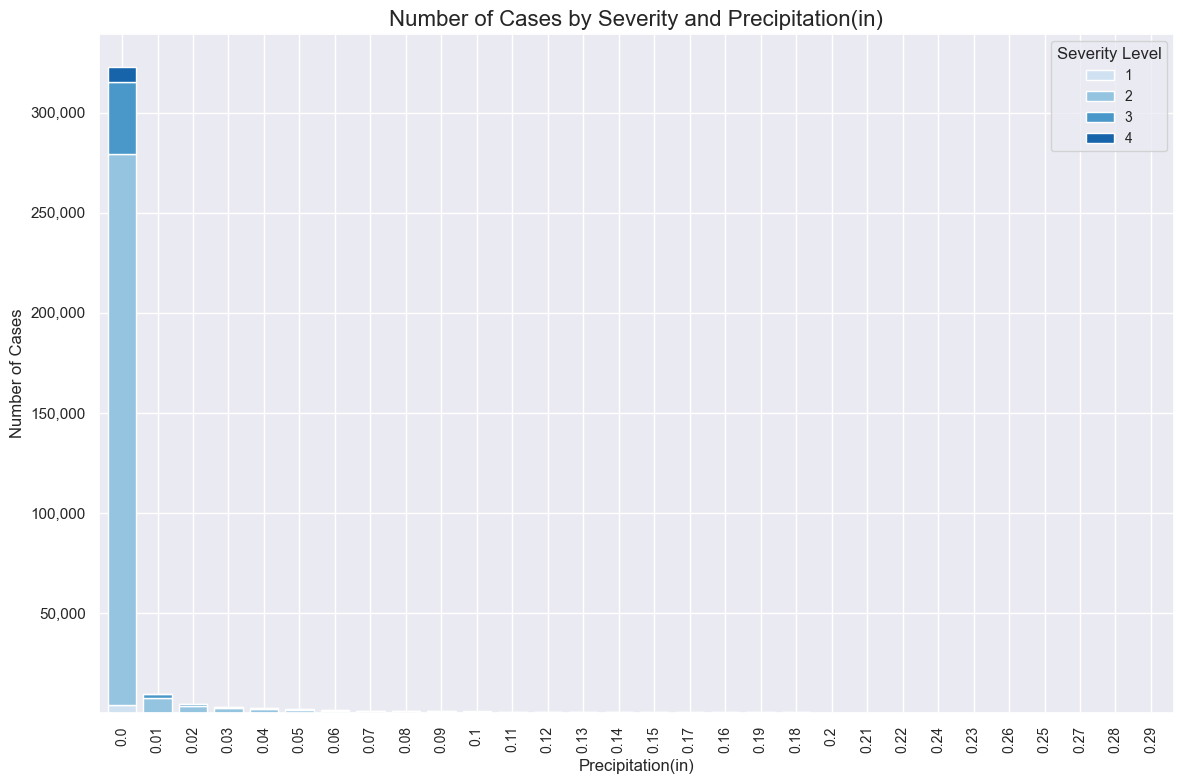

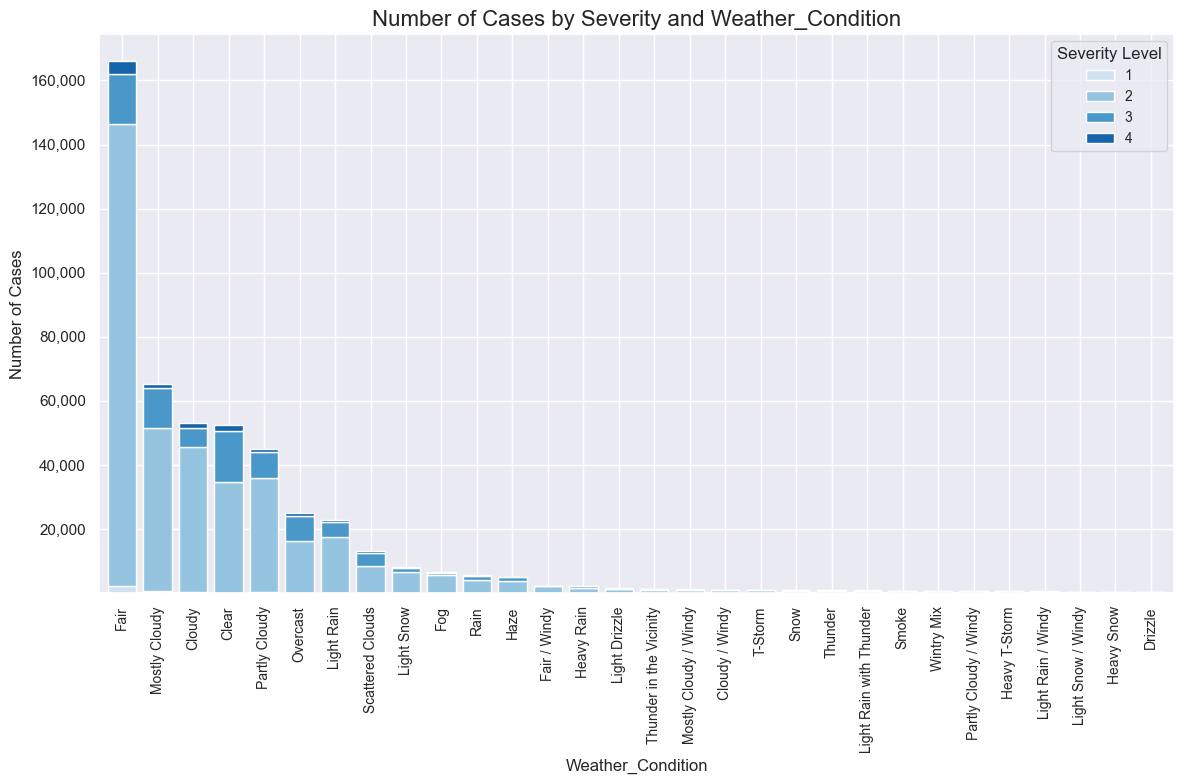

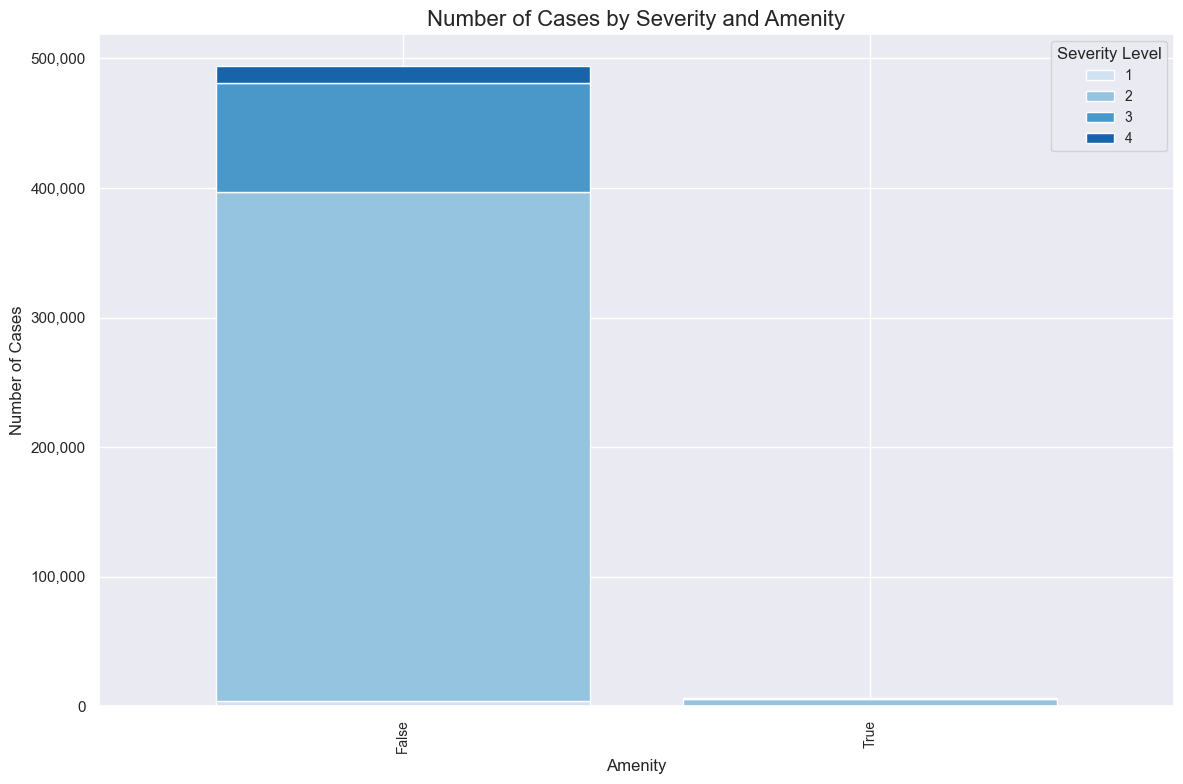

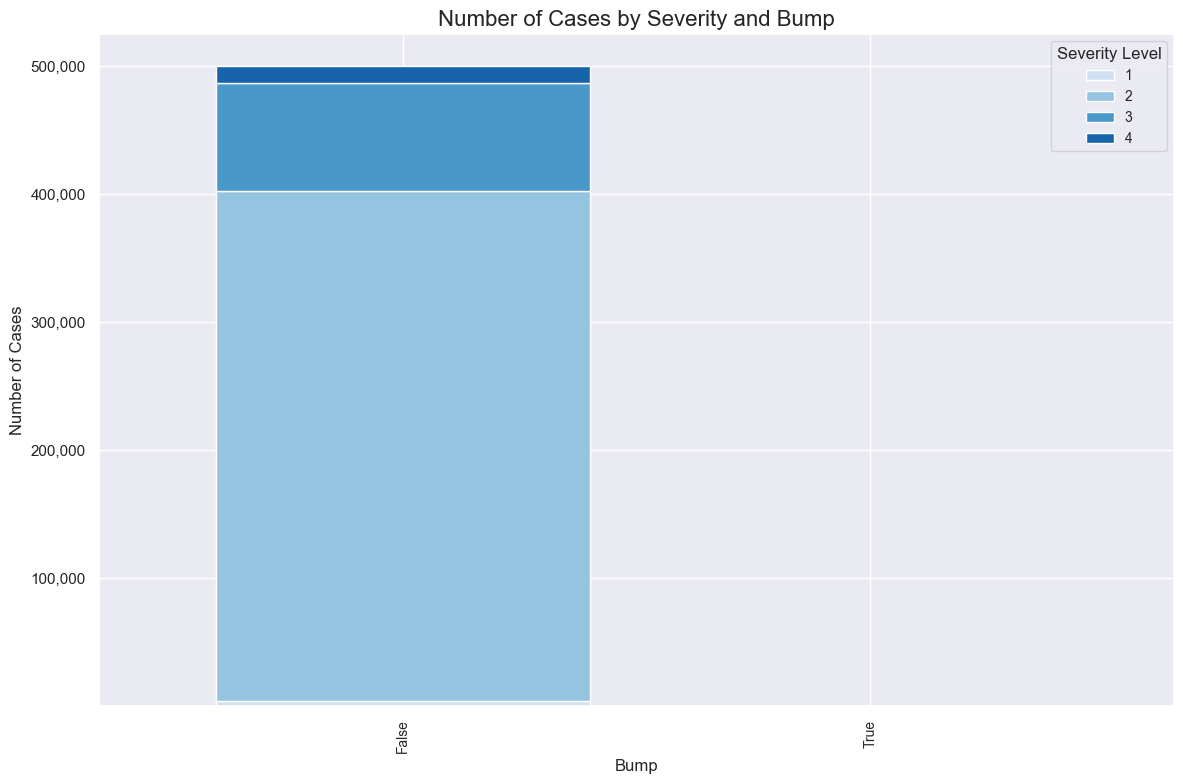

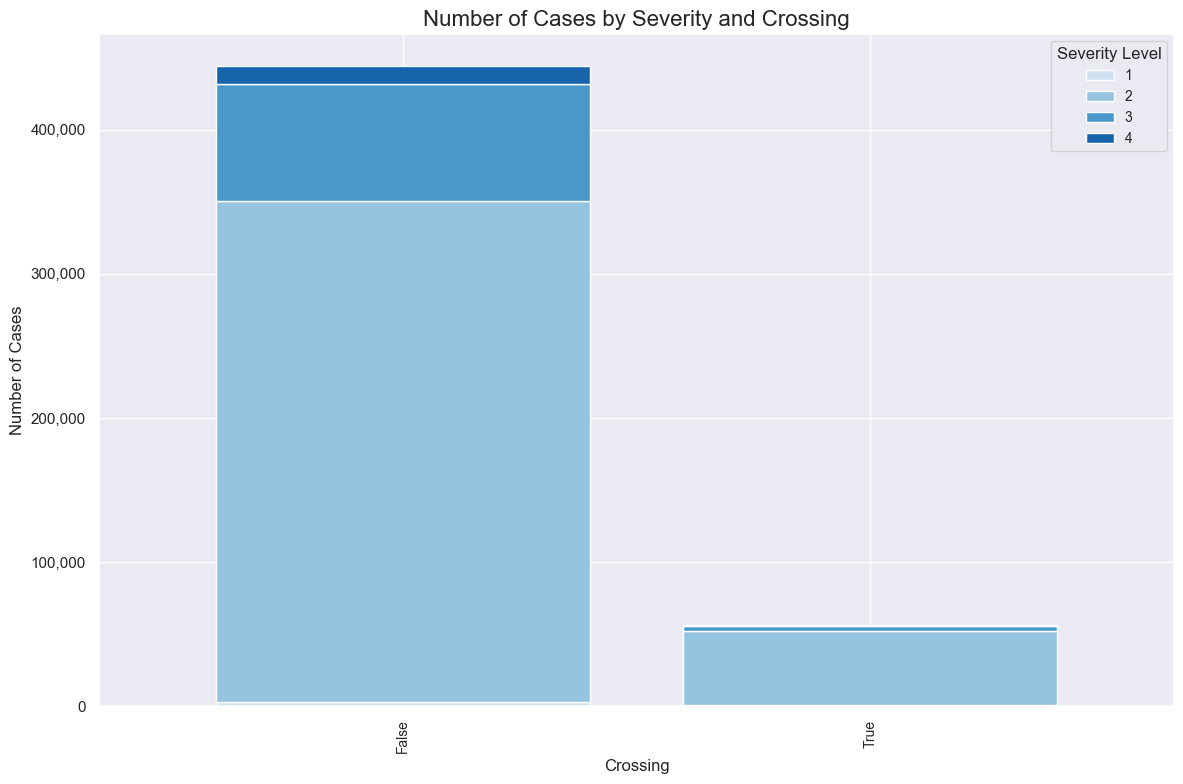

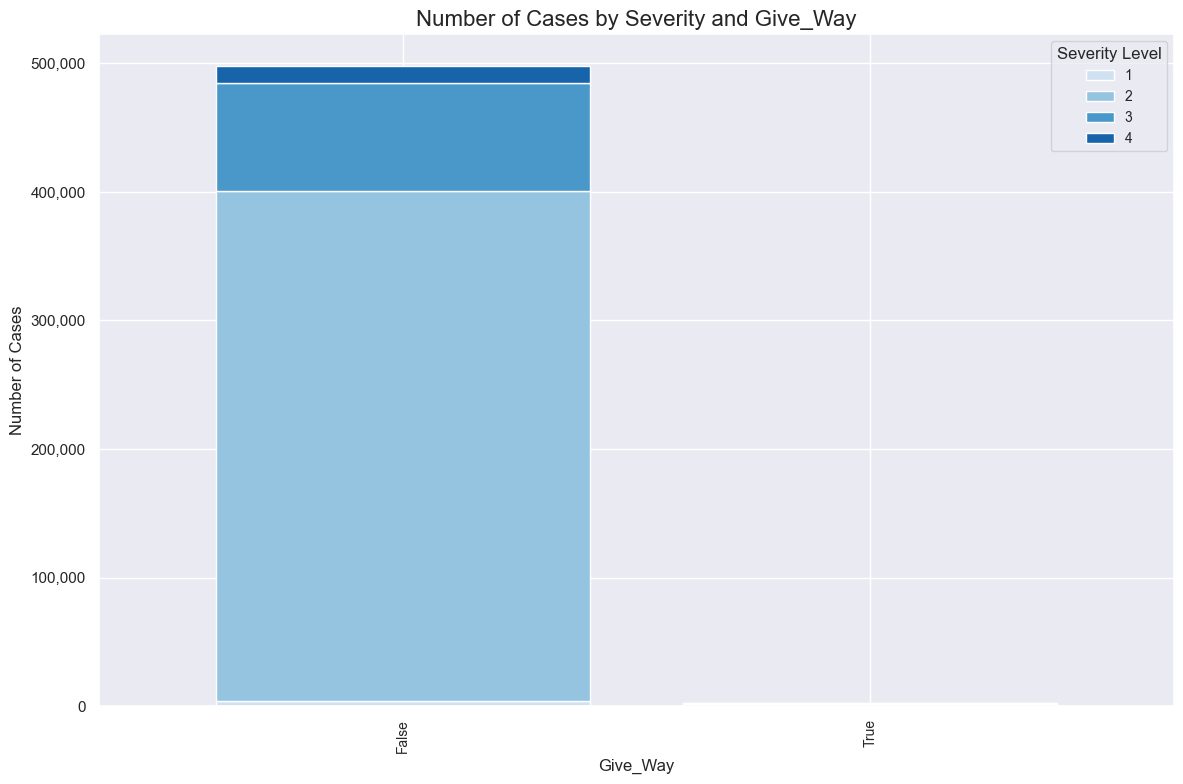

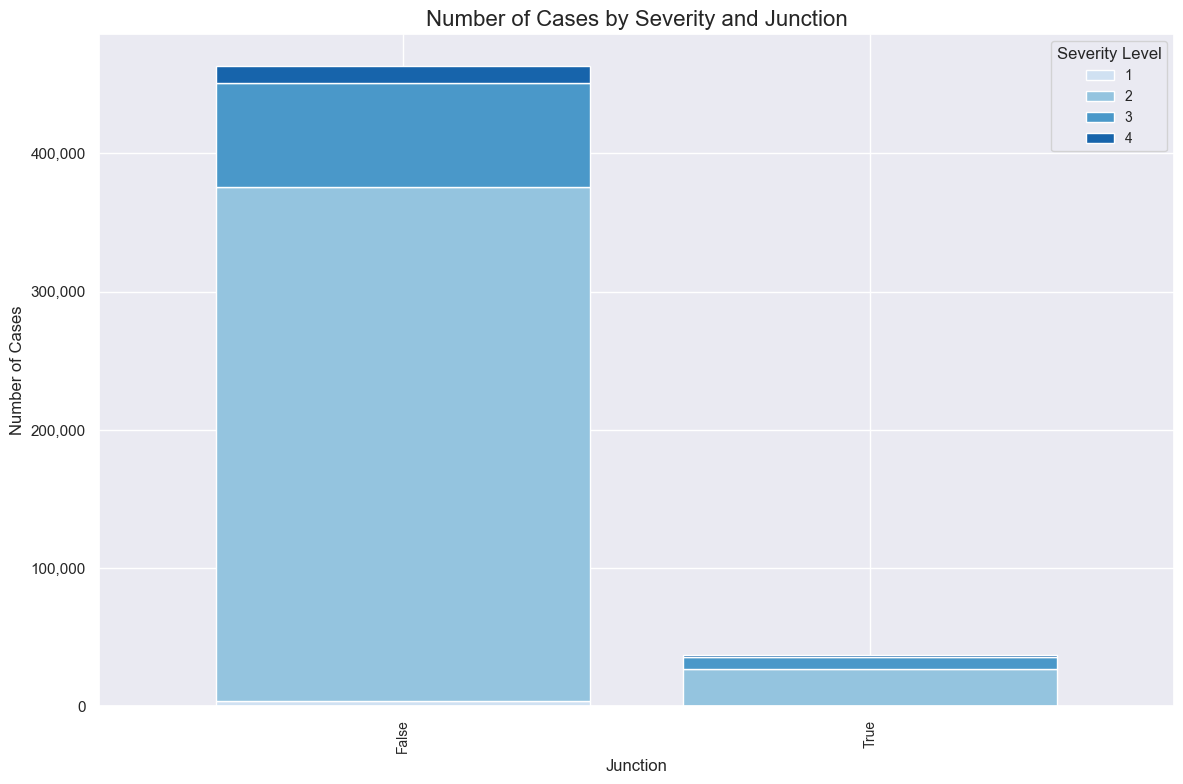

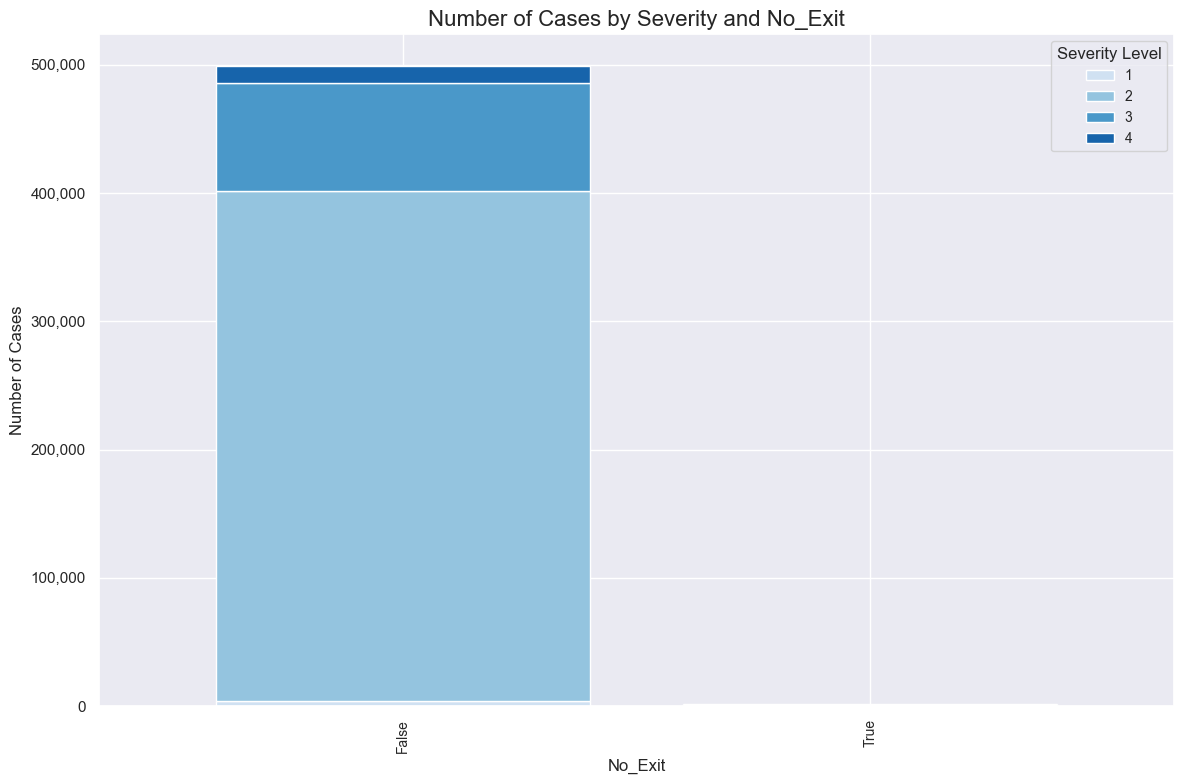

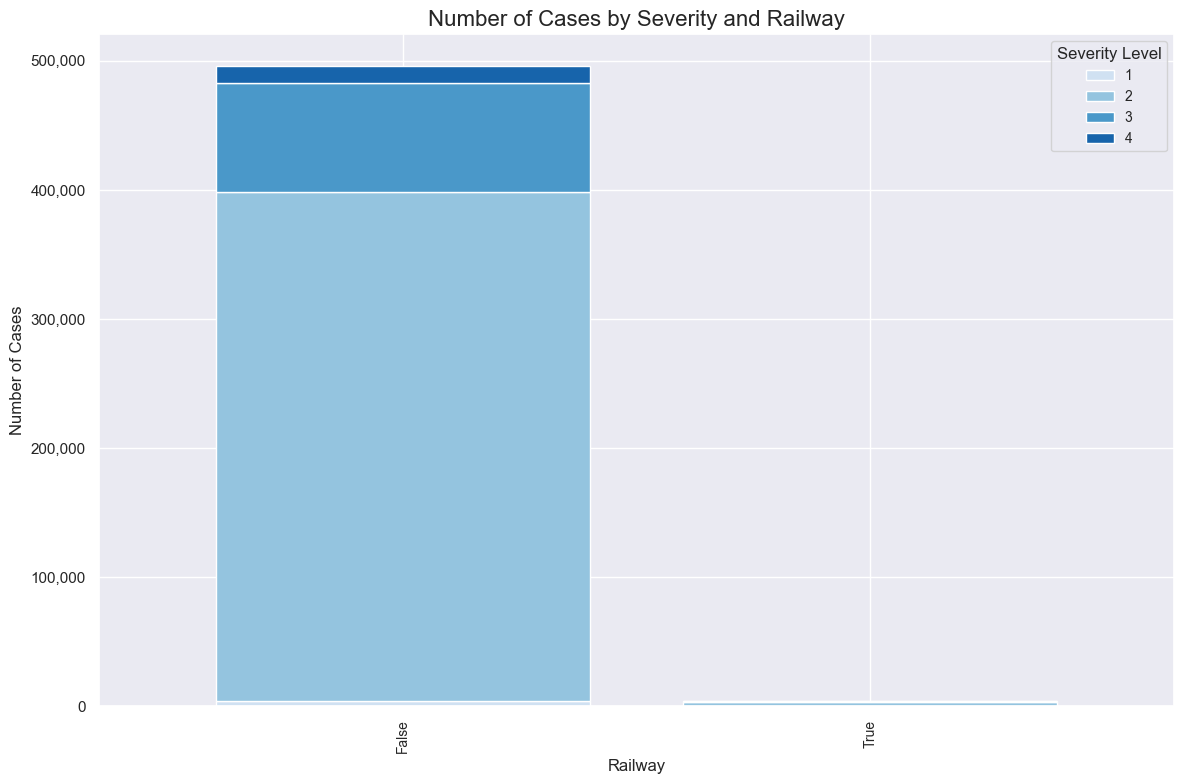

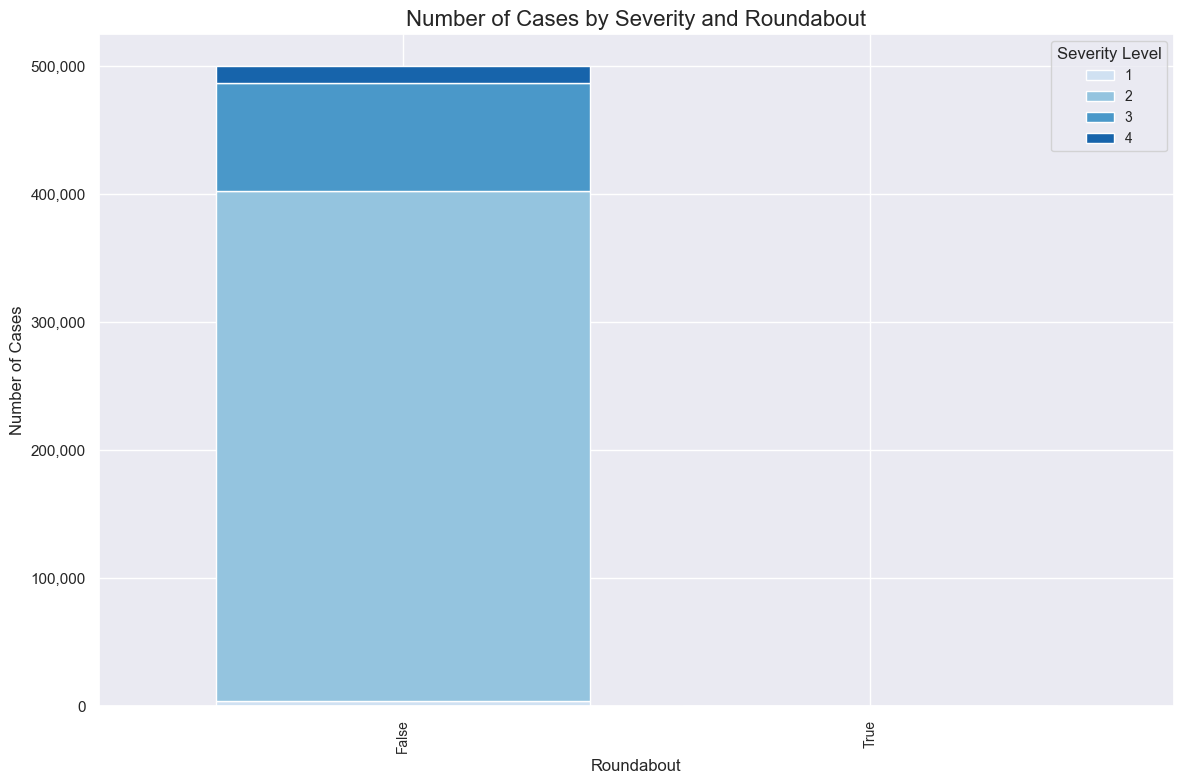

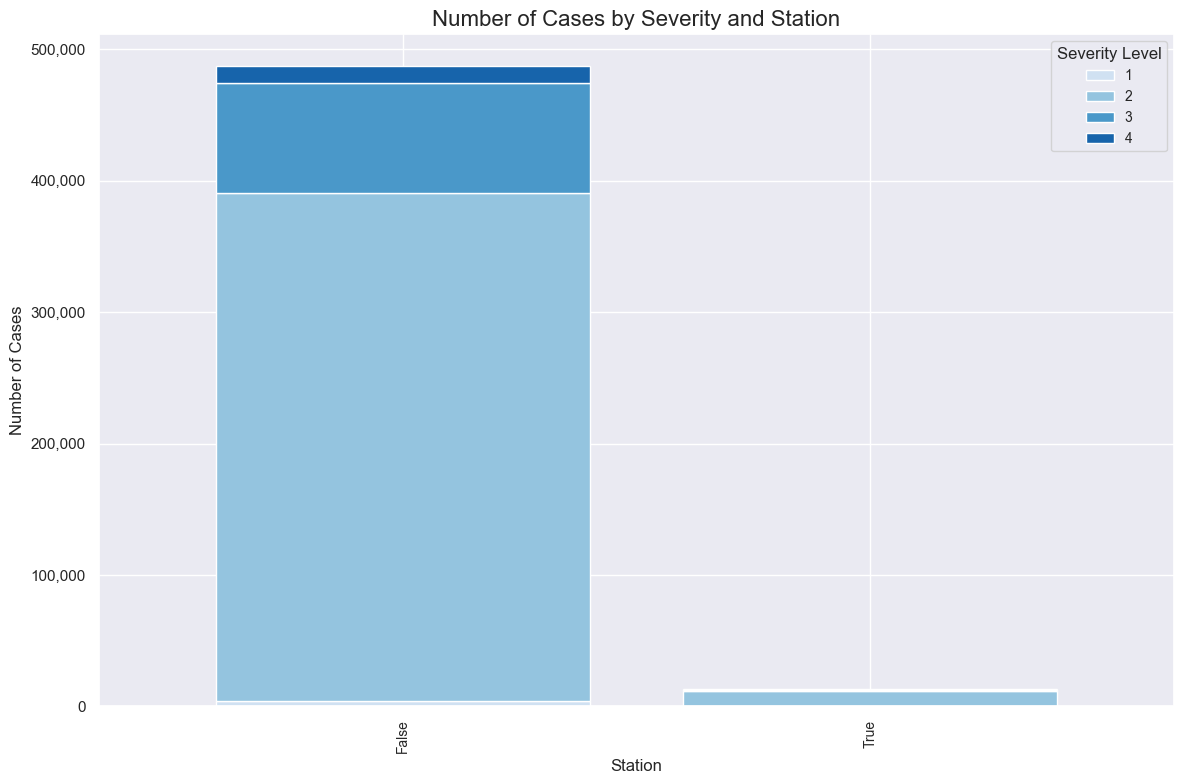

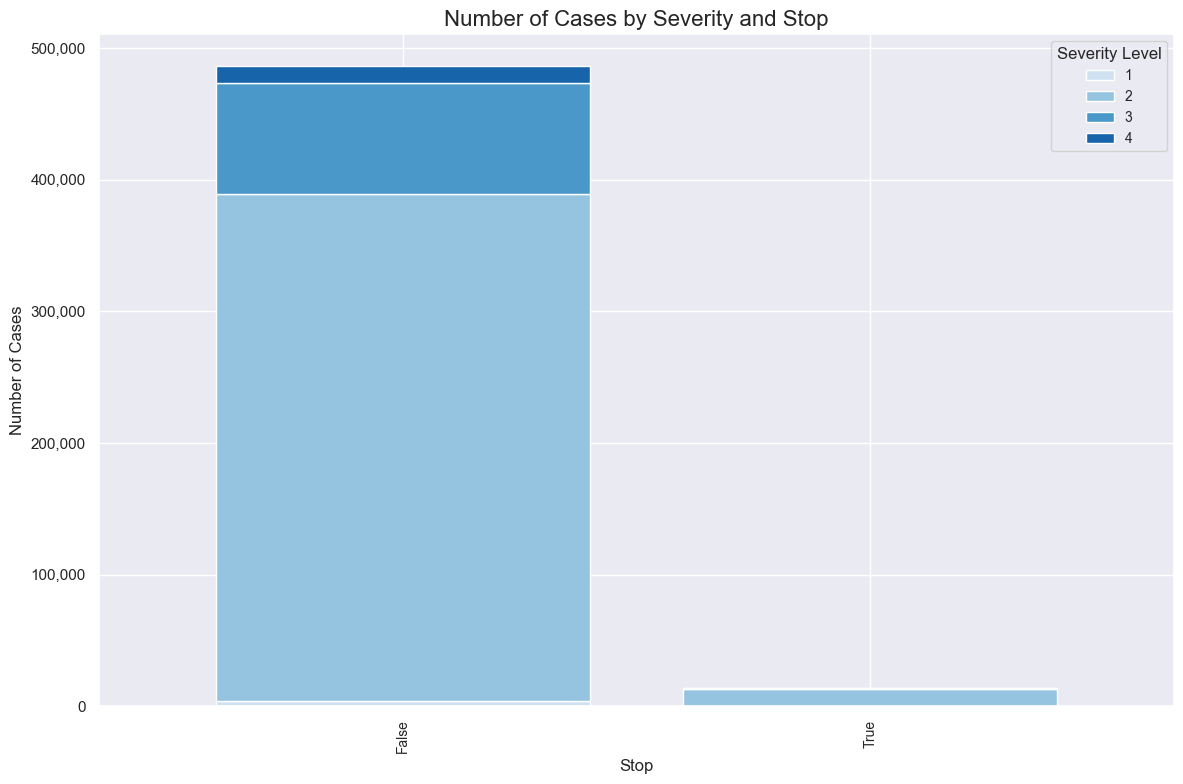

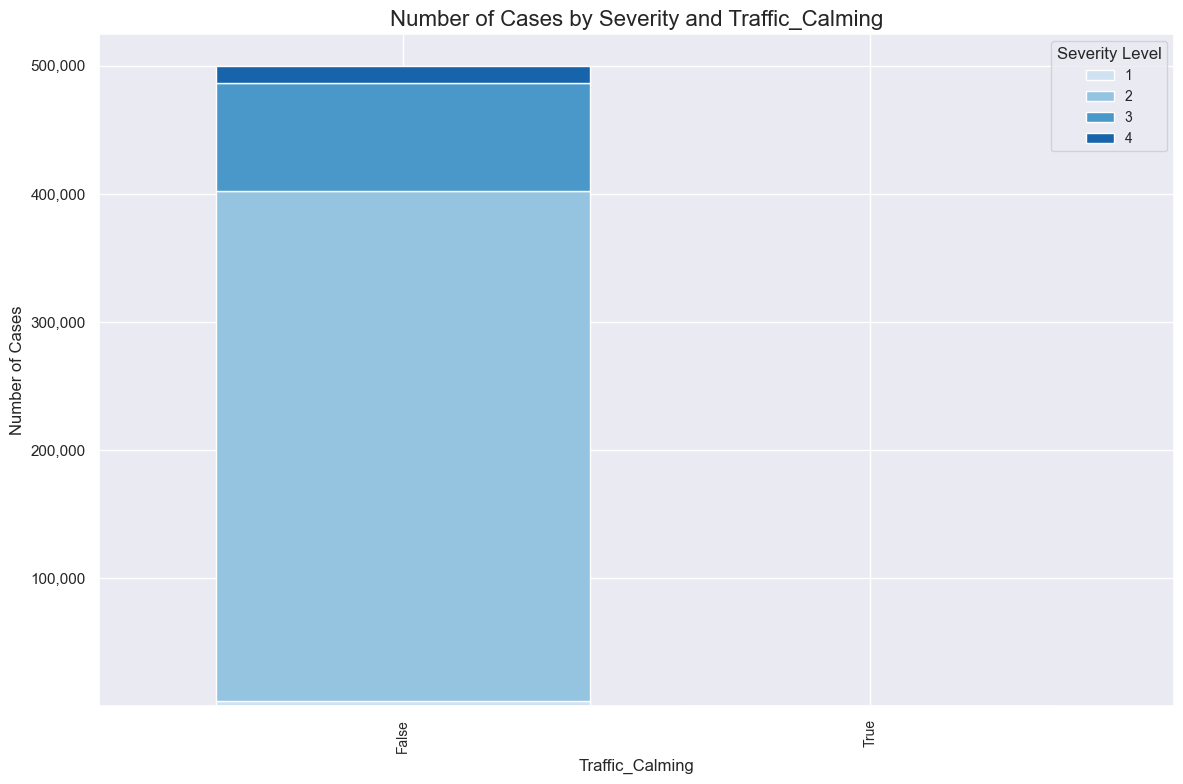

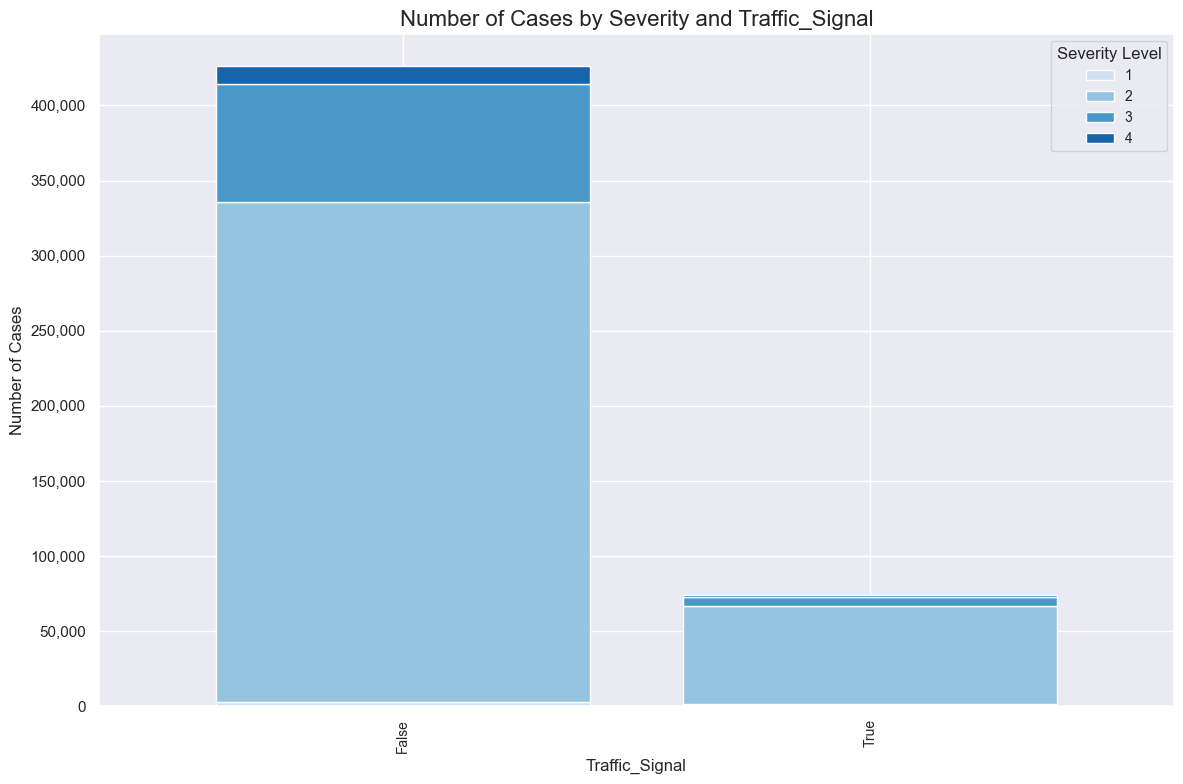

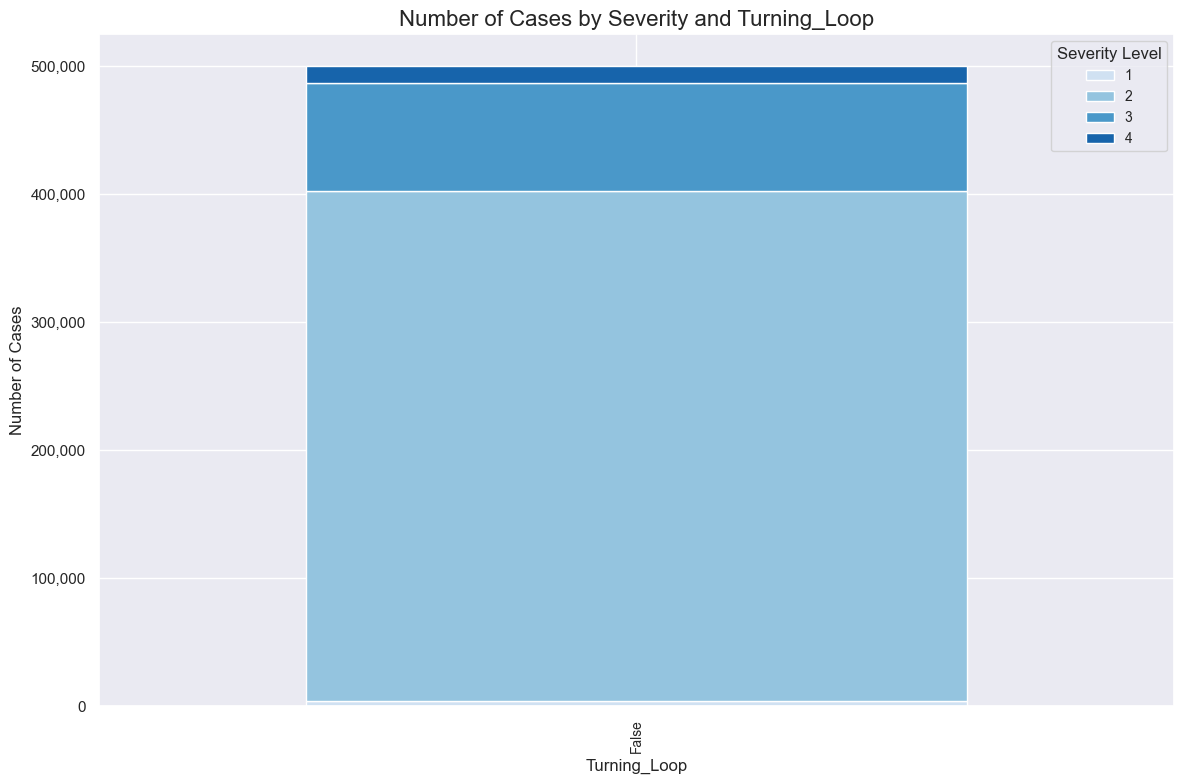

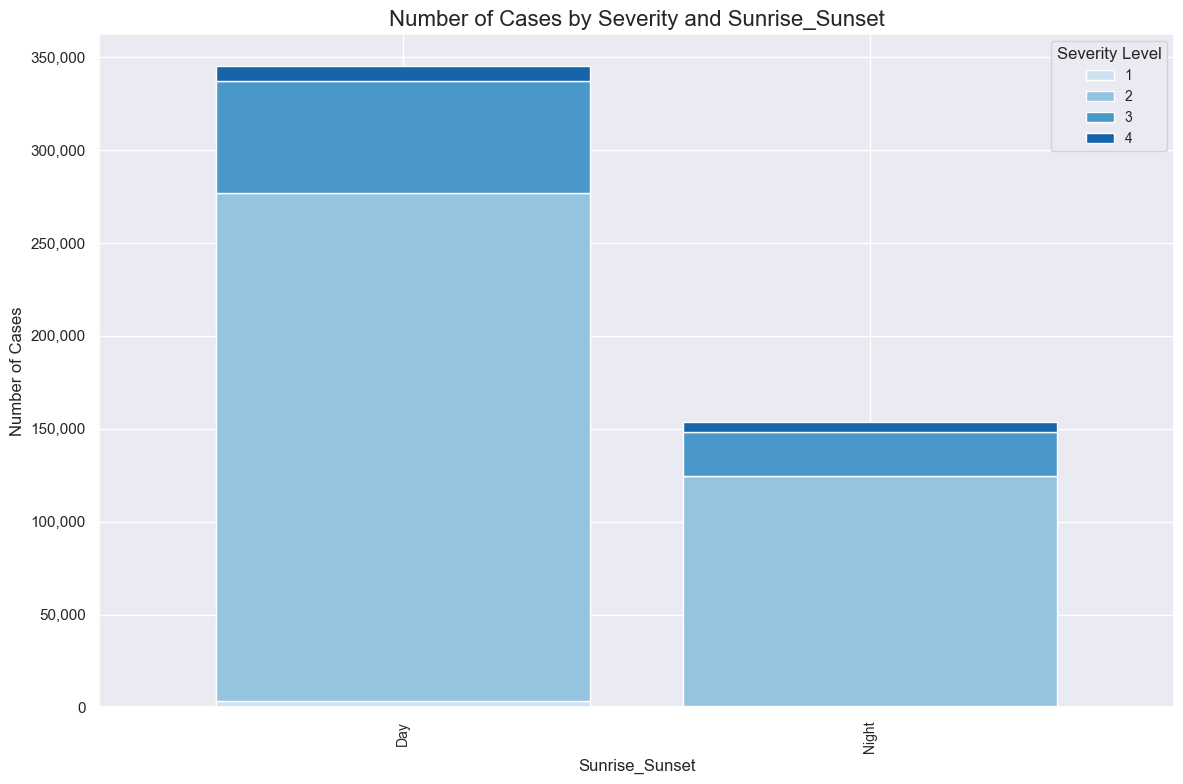

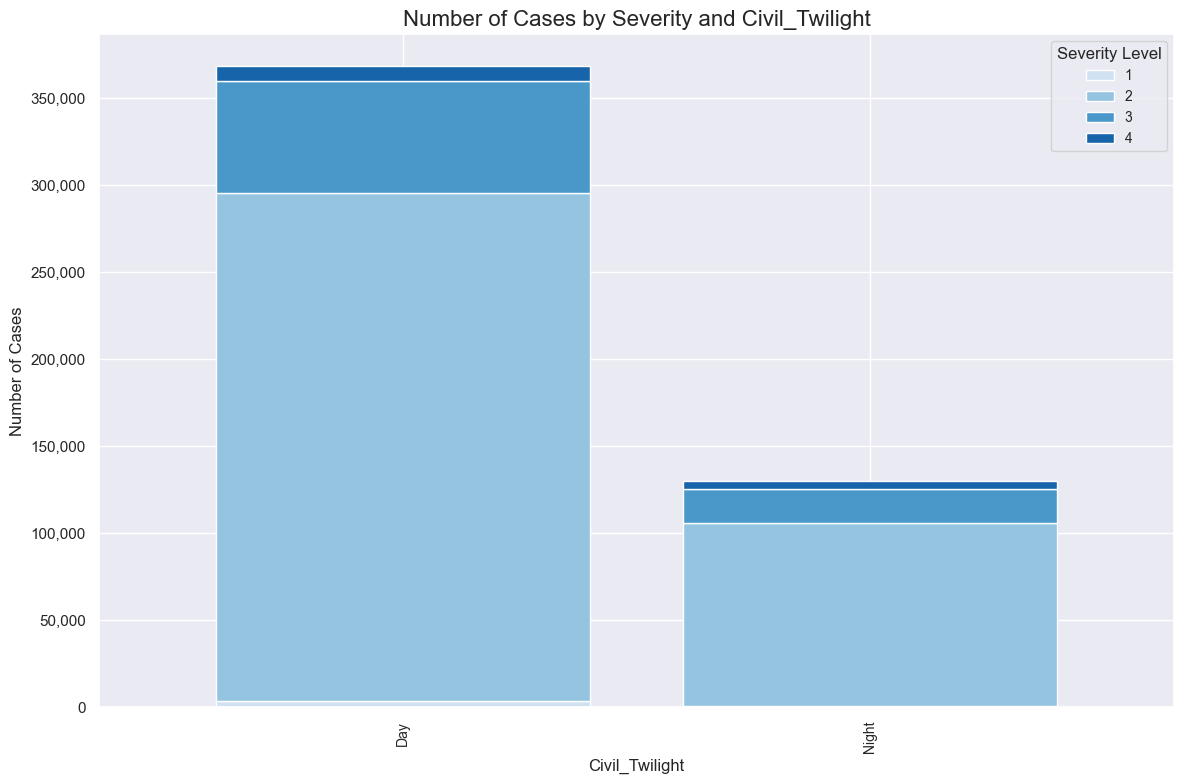

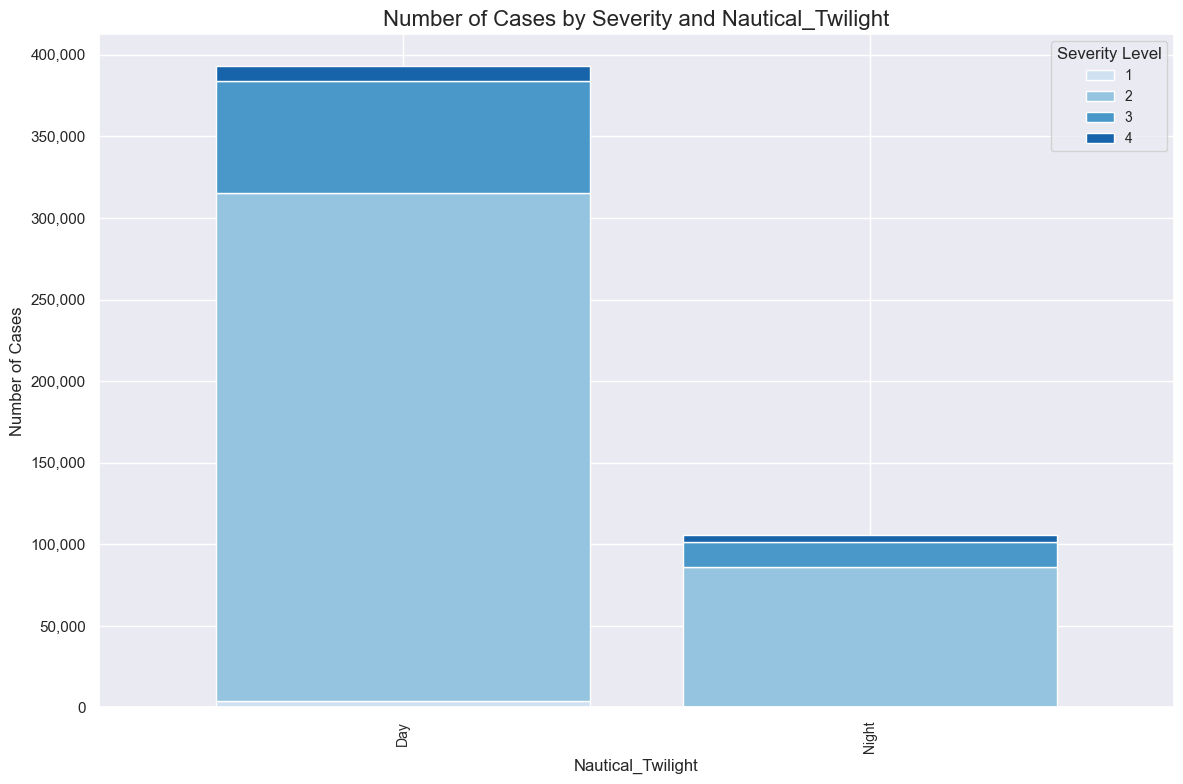

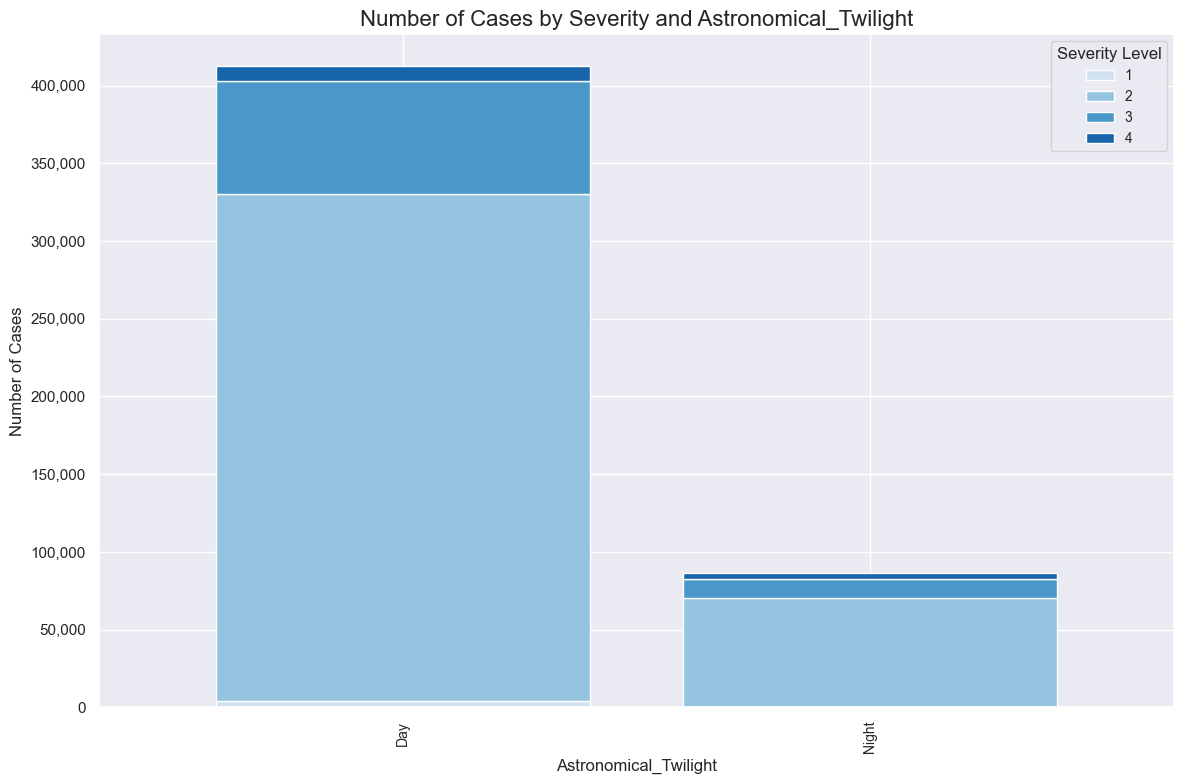

In [35]:
columns_to_plot = ['City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'] 

for column in columns_to_plot: 
    plot_severity_distribution(df, group_by_column=column, top_n=30)

In [11]:
df['Start_Time'] = df['Start_Time'].str.replace(r'\.\d+$', '', regex=True) # removes the fractional seconds (.000000000)
df['End_Time'] = df['End_Time'].str.replace(r'\.\d+$', '', regex=True) 

df['Start_Time'] = pd.to_datetime(df['Start_Time']) 
df['End_Time'] = pd.to_datetime(df['End_Time'])

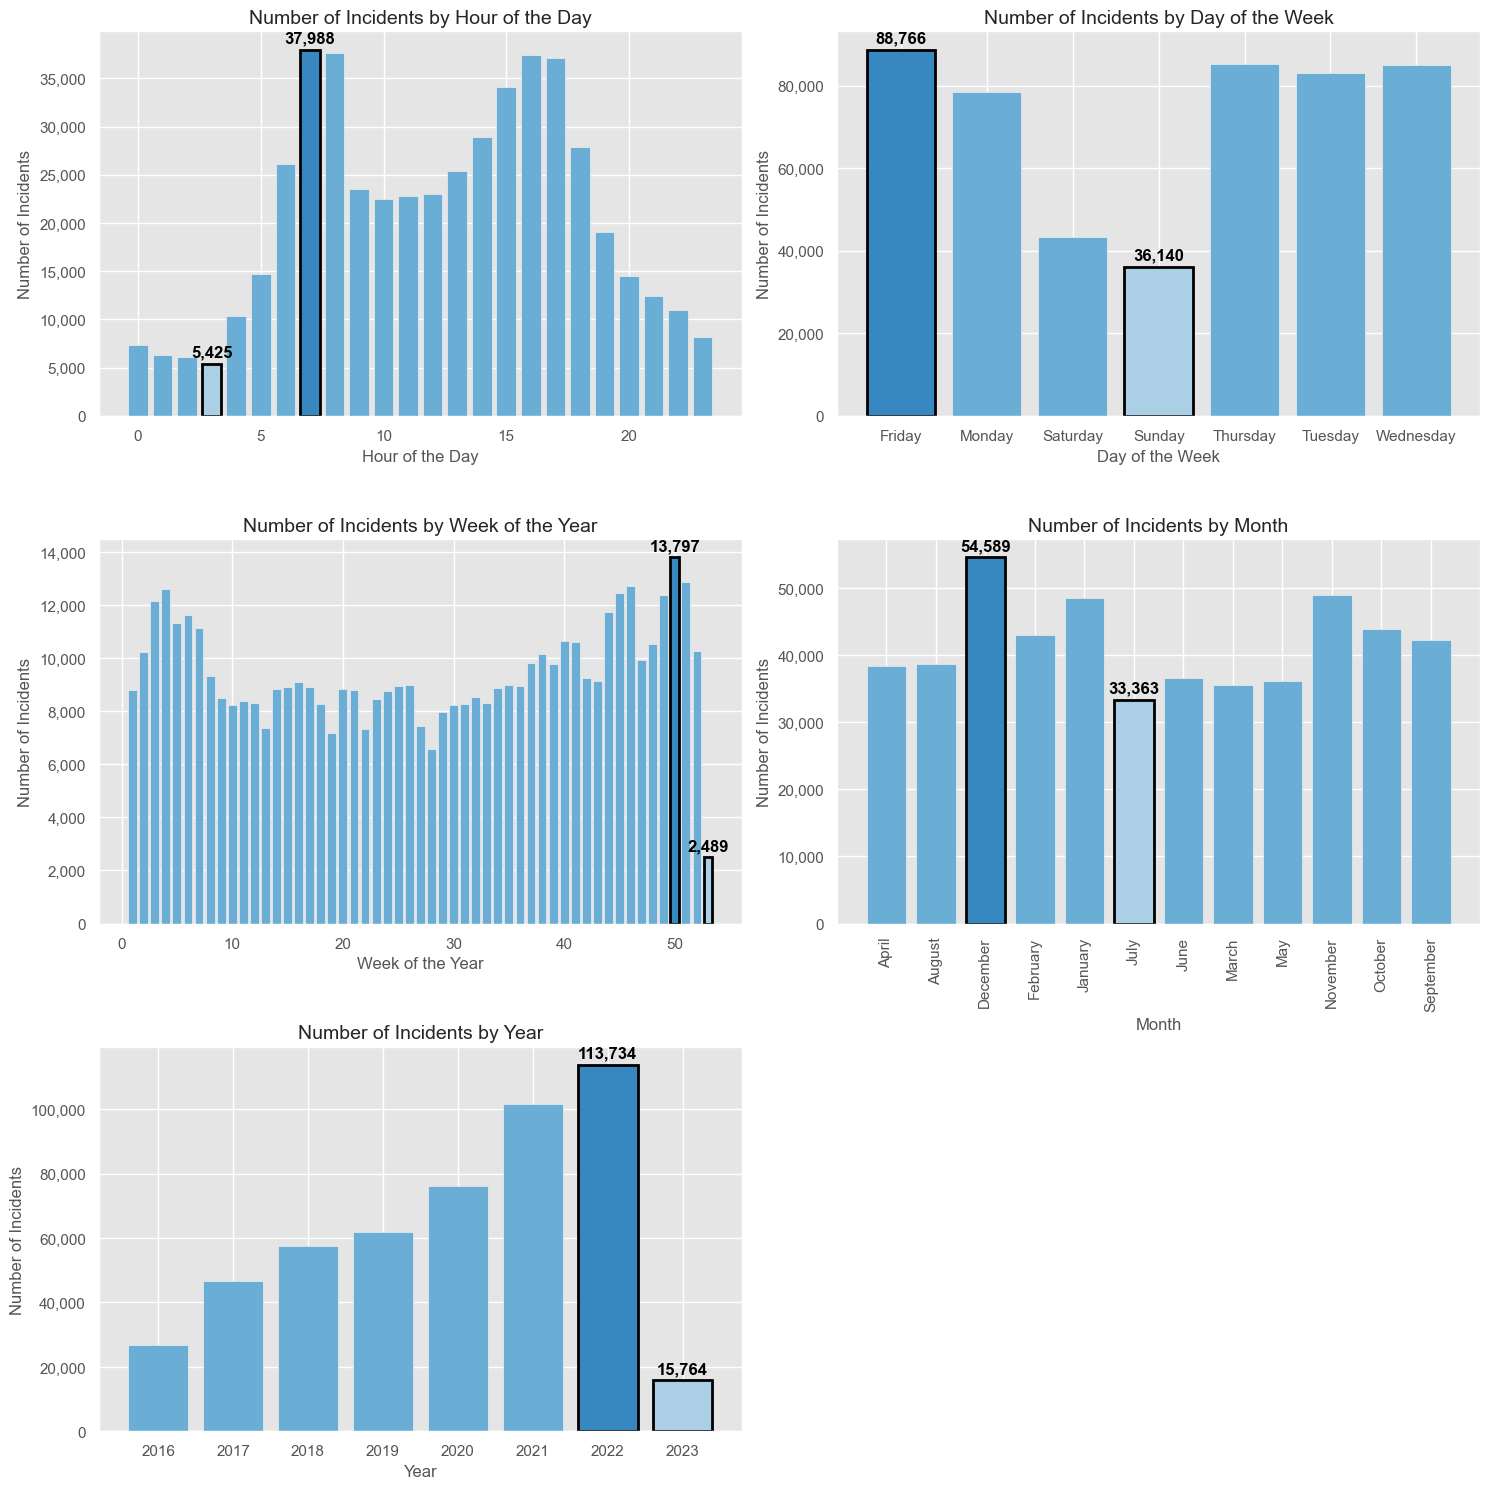

In [ ]:
import matplotlib.ticker as ticker

incident_counts_by_time = df['Start_Time'].dt.hour.value_counts().sort_index()
incident_counts_by_day = df['Start_Time'].dt.day_name().value_counts().sort_index()
incident_counts_by_week = df['Start_Time'].dt.isocalendar().week.value_counts().sort_index()
incident_counts_by_month = df['Start_Time'].dt.month_name().value_counts().sort_index()
incident_counts_by_year = df['Start_Time'].dt.year.value_counts().sort_index()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# colors = ['#d6e6f4', '#abd0e6', '#6aaed6', '#3787c0', '#105ba4']
colors = ['#6aaed6', '#6aaed6', '#6aaed6', '#6aaed6', '#6aaed6']

def annotate_bars(ax, counts):
    # Annotate only the maximum and minimum values
    ax.text(counts.idxmax(), counts.max() + max(counts.values) * 0.02, f"{counts.max():,.0f}", 
            ha="center", fontsize=12, fontweight="bold", color='black')
    ax.text(counts.idxmin(), counts.min() + max(counts.values) * 0.02, f"{counts.min():,.0f}", 
            ha="center", fontsize=12, fontweight="bold", color='black')

    # Highlight max and min bars with different colors
    ax.bar(counts.idxmax(), counts.max(), color='#3787c0', edgecolor='black', linewidth=2, label="Max")  # Highlight max
    ax.bar(counts.idxmin(), counts.min(), color='#abd0e6', edgecolor='black', linewidth=2, label="Min")  # Highlight min


axs[0, 0].bar(incident_counts_by_time.index, incident_counts_by_time.values, color=colors[0])
annotate_bars(axs[0, 0], incident_counts_by_time)
axs[0, 0].set_title('Number of Incidents by Hour of the Day', fontsize=14)
axs[0, 0].set_xlabel('Hour of the Day', fontsize=12)
axs[0, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[0, 1].bar(incident_counts_by_day.index, incident_counts_by_day.values, color=colors[1])
annotate_bars(axs[0, 1], incident_counts_by_day)
axs[0, 1].set_title('Number of Incidents by Day of the Week', fontsize=14)
axs[0, 1].set_xlabel('Day of the Week', fontsize=12)
axs[0, 1].set_ylabel('Number of Incidents', fontsize=12)

axs[1, 0].bar(incident_counts_by_week.index.astype(int), incident_counts_by_week.values, color=colors[2])
annotate_bars(axs[1, 0], incident_counts_by_week)
axs[1, 0].set_title('Number of Incidents by Week of the Year', fontsize=14)
axs[1, 0].set_xlabel('Week of the Year', fontsize=12)
axs[1, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[1, 1].bar(incident_counts_by_month.index, incident_counts_by_month.values, color=colors[3])
annotate_bars(axs[1, 1], incident_counts_by_month)
axs[1, 1].set_title('Number of Incidents by Month', fontsize=14)
axs[1, 1].set_xlabel('Month', fontsize=12) 
axs[1, 1].set_ylabel('Number of Incidents', fontsize=12)
axs[1, 1].tick_params(axis='x', labelrotation=90)

axs[2, 0].bar(incident_counts_by_year.index, incident_counts_by_year.values, color=colors[4])
annotate_bars(axs[2, 0], incident_counts_by_year)
axs[2, 0].set_title('Number of Incidents by Year', fontsize=14)
axs[2, 0].set_xlabel('Year', fontsize=12)
axs[2, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[2, 1].axis('off')

for ax in axs.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

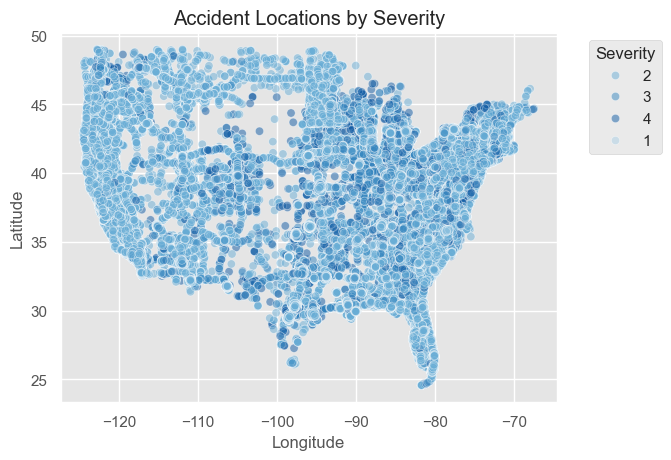

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Severity' is treated as categorical (convert to string if necessary)
df['Severity'] = df['Severity'].astype(str)

# Define a color palette that matches severity levels (assuming 1 to 4 levels)
severity_palette = {
    '1': '#abd0e6',    # Low severity
    '2': '#6aaed6',   # Moderate severity
    '3': '#3787c0',   # High severity
    '4': '#105ba4'     # Very high severity
}

# Create the scatterplot with the updated palette
sns.scatterplot(
    x=df['Start_Lng'], 
    y=df['Start_Lat'], 
    hue=df['Severity'], 
    palette=severity_palette,  # Map severity to the custom colors
    # size=df['Severity'].map(df['Severity'].value_counts()),  # Size by frequency of severity
    alpha=0.5
)

plt.title("Accident Locations by Severity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


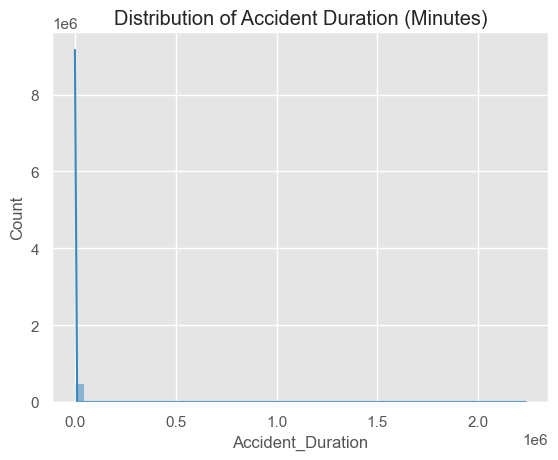

In [89]:
# df['Start_Time'] = df['Start_Time'].str.split('.').str[0]  # Remove nanoseconds
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S')

# df['End_Time'] = df['End_Time'].str.split('.').str[0]  # Remove nanoseconds
df['End_Time'] = pd.to_datetime(df['End_Time'], format='%Y-%m-%d %H:%M:%S')


df['Accident_Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
sns.histplot(df['Accident_Duration'], bins=50, kde=True, color='#3787c0')
plt.title("Distribution of Accident Duration (Minutes)")
plt.show()


/var/folders/m_/kb9mf0b90hb2fvtfccyd41fr0000gn/T/ipykernel_58943/1978968240.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Severity', y='Accident_Duration', palette='dark:skyblue')


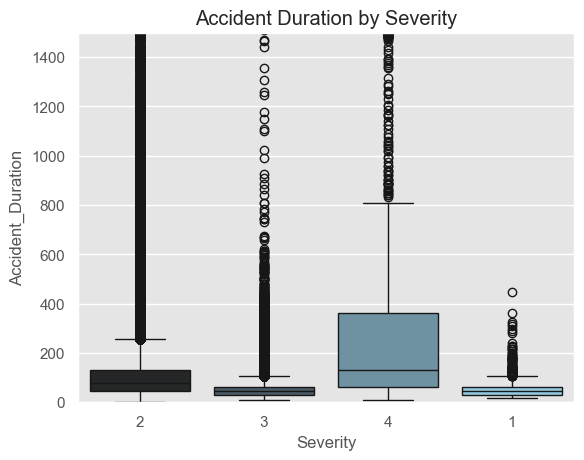

In [91]:
sns.boxplot(data=df, x='Severity', y='Accident_Duration', palette='dark:skyblue')
plt.ylim(0, 1500)  # Limit extreme values for readability
plt.title("Accident Duration by Severity")
plt.show()
